<a href="https://colab.research.google.com/github/janehseo/CSC2516_NeuralNetsandDeepLearning/blob/main/Team42_CSC2516Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Imports

In [ ]:
from pathlib import Path
import numpy as np
from numpy import mean
from numpy import std
from numpy import dstack
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as Data
import matplotlib.pyplot as plt
import pandas as pd
import sys
from importlib import reload
import matplotlib.gridspec as gridspec
from functools import lru_cache
import datetime
import pprint 

In [ ]:
data_folder = Path("drive/MyDrive")
file = data_folder / "data/ptbxl/export/rhythm.npz"
util = data_folder / "util.py" # Helper functions
if not file.exists():
    data_folder = Path("drive/MyDrive/CSC2516_PTBXL")
    file = data_folder / "data/ptbxl/export/rhythm.npz"
    util = data_folder / "util.py"

assert file.exists(), f"Data file {file} does not exist"
assert util.exists(), f"Util script {util} does not exist"

sys.path.append(str(util.parent))

import util
reload(util)

<module 'util' from 'drive/MyDrive/CSC2516_PTBXL/util.py'>

# Dataset characteristics - Don't need to run this

In [ ]:
dataset = util.PTBXLDataset(file, "train")
dataset.X.shape

(16854, 1000, 12)

In [ ]:
dataset = util.PTBXLDataset(file, "val")
dataset.X.shape

Loading file = drive/MyDrive/CSC2516_PTBXL/data/ptbxl/export/rhythm.npz key = X_val
Loading file = drive/MyDrive/CSC2516_PTBXL/data/ptbxl/export/rhythm.npz key = y_val


(2109, 1000, 12)

In [ ]:
dataset = util.PTBXLDataset(file, "test")
dataset.X.shape

Loading file = drive/MyDrive/CSC2516_PTBXL/data/ptbxl/export/rhythm.npz key = X_test
Loading file = drive/MyDrive/CSC2516_PTBXL/data/ptbxl/export/rhythm.npz key = y_test


(2103, 1000, 12)

In [ ]:
dataset.label_counts(normalize=True)

description  sinus rhythm  ...  trigeminal pattern (unknown origin, SV or Ventricular)
0                0.928148  ...                                           0.999051     
1                0.071852  ...                                           0.000949     

[2 rows x 12 columns]

In [ ]:

X = dataset.X[504, ...]
print(pd.Series(dataset.y[504, ...], index=dataset.statements["description"]))

fig, axes = util.plot_ecg(X, figsize=(8.5, 4))
fig.savefig(f"{dataset.file.stem}_{504}_sinus tachycardia_atrial flutter.pdf")


# Define models - Run this

## MLP

In [ ]:
class MLP(nn.Module):
    def __init__(self, in_features, out_features, hidden=4096):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_features, hidden),
            nn.ReLU(),
            nn.Linear(hidden, out_features),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.mlp(x.flatten(start_dim=1))


## CNN

In [ ]:

class CNN(nn.Module):
    """
    Reference: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
    """
    def __init__(
        self, 
        in_channels=12, 
        out_features=12, 
        channels=(512, 128), 
        kernel_size=10, 
        hidden_size=256,
        verbose=False
    ):
        super().__init__()
        # self.pool = nn.MaxPool1d(kernel_size=kernel_size)
        # self.conv1 = nn.Conv1d(in_channels=in_channels, 
        #                        out_channels=channels[0], 
        #                        kernel_size=kernel_size)
        # self.norm1 = nn.BatchNorm1d(channels[0])
        # self.conv2 = nn.Conv1d(channels[0], channels[1], kernel_size)
        # self.norm2 = nn.BatchNorm1d(channels[1])
        self.conv_block = nn.Sequential(
            nn.Conv1d(in_channels=in_channels, 
                      out_channels=channels[0], 
                      kernel_size=kernel_size),
            nn.BatchNorm1d(channels[0]),
            nn.MaxPool1d(kernel_size=kernel_size),
            nn.Conv1d(channels[0], channels[1], kernel_size),
            nn.BatchNorm1d(channels[1]),
            nn.MaxPool1d(kernel_size=kernel_size),
        )
        output_from_conv = self.conv_block(torch.zeros(1, 12, 1000))
        if verbose:
            print(f"CNN block output shape = {output_from_conv.shape}")
        self.fc1 = nn.Linear(channels[1] * output_from_conv.shape[-1], hidden_size)
        self.fc2 = nn.Linear(hidden_size, out_features)
        self.verbose = verbose

    def forward(self, x):
        # Convert data from batch x 1000 x 12 
        # to batch x 12 x 1000
        # which is the Conv1d format
        x = x.transpose(2, 1)
        batch, _, _ = x.shape
        # assert x.shape == (batch, 12, 1000)

        # x = self.norm1(torch.relu(self.pool(self.conv1(x))))
        # if self.verbose:
        #     print("After conv1: ", x.shape)
        # x = self.norm2(torch.relu(self.pool(self.conv2(x))))
        # if self.verbose:
        #     print("After conv2: ", x.shape)
        x = self.conv_block(x)

        # x = x.view(-1, 64 * 9)
        x = F.relu(self.fc1(x.flatten(start_dim=1)))
        x = self.fc2(x)
        x = torch.sigmoid(x)

        return x

## LSTM

In [ ]:
class LSTM1(nn.Module):
    """
    From Copy of model_bidirlstm.ipynb
    Updated 2021/04/17
    """
    def __init__(self,
                 input_channels,
                 output_channels,
                 seq_length,
                 hidden_dim=256,num_layers=2,bidirectional=True,
                 mlp_hidden_size=256):
        
        super(LSTM1, self).__init__()

        self.input_channels = input_channels
        self.output_channels = output_channels
        self.seq_length = seq_length
        
        self.rnn = nn.LSTM(input_size=input_channels,hidden_size=hidden_dim,num_layers=num_layers,bidirectional=bidirectional, batch_first=True)
        self.lin = nn.Linear(hidden_dim*seq_length*2, mlp_hidden_size)
        self.lin2 = nn.Linear(mlp_hidden_size, output_channels)

    def forward(self, x):
        batch, seq, feature = x.shape

        x, (h_n, c_n) = self.rnn(x)
        # assert x.shape == (batch, seq, net.rnn.hidden_size)

        x = x.flatten(start_dim=1)
        # assert x.shape == (batch, seq * net.rnn.hidden_size)

        x = self.lin(x)
        x = F.relu(x)
        x = self.lin2(x)
        # assert x.shape == (batch, self.output_channels)

        # Sigmoid activation before Binary Cross Entropy
        x = torch.sigmoid(x)

        return x
    

## Resnet1D

In [ ]:
# https://github.com/hsd1503/resnet1d/blob/master/resnet1d.py

"""
Copied from Copy of resnet1d
Copied on 2021/04/16
Added two lines below with comments marked by ##########################
"""

class MyConv1dPadSame(nn.Module):
    """
    extend nn.Conv1d to support SAME padding
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride, groups=1):
        super(MyConv1dPadSame, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.groups = groups
        self.conv = torch.nn.Conv1d(
            in_channels=self.in_channels, 
            out_channels=self.out_channels, 
            kernel_size=self.kernel_size, 
            stride=self.stride, 
            groups=self.groups)

    def forward(self, x):
        
        net = x
        
        # compute pad shape
        in_dim = net.shape[-1]
        out_dim = (in_dim + self.stride - 1) // self.stride
        p = max(0, (out_dim - 1) * self.stride + self.kernel_size - in_dim)
        pad_left = p // 2
        pad_right = p - pad_left
        net = F.pad(net, (pad_left, pad_right), "constant", 0)
        
        net = self.conv(net)

        return net

class MyMaxPool1dPadSame(nn.Module):
    """
    extend nn.MaxPool1d to support SAME padding
    """
    def __init__(self, kernel_size):
        super(MyMaxPool1dPadSame, self).__init__()
        self.kernel_size = kernel_size
        self.stride = 1
        self.max_pool = torch.nn.MaxPool1d(kernel_size=self.kernel_size)

    def forward(self, x):
        
        net = x
        
        # compute pad shape
        in_dim = net.shape[-1]
        out_dim = (in_dim + self.stride - 1) // self.stride
        p = max(0, (out_dim - 1) * self.stride + self.kernel_size - in_dim)
        pad_left = p // 2
        pad_right = p - pad_left
        net = F.pad(net, (pad_left, pad_right), "constant", 0)
        
        net = self.max_pool(net)
        
        return net
class BasicBlock(nn.Module):
    """
    ResNet Basic Block
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride, groups, downsample, use_bn, use_do, is_first_block=False):
        super(BasicBlock, self).__init__()
        
        self.in_channels = in_channels
        self.kernel_size = kernel_size
        self.out_channels = out_channels
        self.stride = stride
        self.groups = groups
        self.downsample = downsample
        if self.downsample:
            self.stride = stride
        else:
            self.stride = 1
        self.is_first_block = is_first_block
        self.use_bn = use_bn
        self.use_do = use_do

        # the first conv
        self.bn1 = nn.BatchNorm1d(in_channels)
        self.relu1 = nn.ReLU()
        self.do1 = nn.Dropout(p=0.5)
        self.conv1 = MyConv1dPadSame(
            in_channels=in_channels, 
            out_channels=out_channels, 
            kernel_size=kernel_size, 
            stride=self.stride,
            groups=self.groups)

        # the second conv
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.relu2 = nn.ReLU()
        self.do2 = nn.Dropout(p=0.5)
        self.conv2 = MyConv1dPadSame(
            in_channels=out_channels, 
            out_channels=out_channels, 
            kernel_size=kernel_size, 
            stride=1,
            groups=self.groups)
                
        self.max_pool = MyMaxPool1dPadSame(kernel_size=self.stride)

    def forward(self, x):
        
        identity = x
        
        # the first conv
        out = x
        if not self.is_first_block:
            if self.use_bn:
                out = self.bn1(out)
            out = self.relu1(out)
            if self.use_do:
                out = self.do1(out)
        out = self.conv1(out)
        
        # the second conv
        if self.use_bn:
            out = self.bn2(out)
        out = self.relu2(out)
        if self.use_do:
            out = self.do2(out)
        out = self.conv2(out)
        
        # if downsample, also downsample identity
        if self.downsample:
            identity = self.max_pool(identity)
            
        # if expand channel, also pad zeros to identity
        if self.out_channels != self.in_channels:
            identity = identity.transpose(-1,-2)
            ch1 = (self.out_channels-self.in_channels)//2
            ch2 = self.out_channels-self.in_channels-ch1
            identity = F.pad(identity, (ch1, ch2), "constant", 0)
            identity = identity.transpose(-1,-2)
        
        # shortcut
        out += identity

        return out

class ResNet1D(nn.Module):
    """
    
    Input:
        X: (n_samples, n_channel, n_length)
        Y: (n_samples)
        
    Output:
        out: (n_samples)
        
    Pararmetes:
        in_channels: dim of input, the same as n_channel
        base_filters: number of filters in the first several Conv layer, it will double at every 4 layers
        kernel_size: width of kernel
        stride: stride of kernel moving
        groups: set larget to 1 as ResNeXt
        n_block: number of blocks
        n_classes: number of classes
        
    """

    def __init__(self, in_channels, base_filters, kernel_size, stride, groups, n_block, n_classes, downsample_gap=2, increasefilter_gap=4, use_bn=True, use_do=True, verbose=False):
        super(ResNet1D, self).__init__()
        
        self.verbose = verbose
        self.n_block = n_block
        self.kernel_size = kernel_size
        self.stride = stride
        self.groups = groups
        self.use_bn = use_bn
        self.use_do = use_do

        self.downsample_gap = downsample_gap # 2 for base model
        self.increasefilter_gap = increasefilter_gap # 4 for base model

        # first block
        self.first_block_conv = MyConv1dPadSame(in_channels=in_channels, out_channels=base_filters, kernel_size=self.kernel_size, stride=1)
        self.first_block_bn = nn.BatchNorm1d(base_filters)
        self.first_block_relu = nn.ReLU()
        out_channels = base_filters
                
        # residual blocks
        self.basicblock_list = nn.ModuleList()
        for i_block in range(self.n_block):
            # is_first_block
            if i_block == 0:
                is_first_block = True
            else:
                is_first_block = False
            # downsample at every self.downsample_gap blocks
            if i_block % self.downsample_gap == 1:
                downsample = True
            else:
                downsample = False
            # in_channels and out_channels
            if is_first_block:
                in_channels = base_filters
                out_channels = in_channels
            else:
                # increase filters at every self.increasefilter_gap blocks
                in_channels = int(base_filters*2**((i_block-1)//self.increasefilter_gap))
                if (i_block % self.increasefilter_gap == 0) and (i_block != 0):
                    out_channels = in_channels * 2
                else:
                    out_channels = in_channels
            
            tmp_block = BasicBlock(
                in_channels=in_channels, 
                out_channels=out_channels, 
                kernel_size=self.kernel_size, 
                stride = self.stride, 
                groups = self.groups, 
                downsample=downsample, 
                use_bn = self.use_bn, 
                use_do = self.use_do, 
                is_first_block=is_first_block)
            self.basicblock_list.append(tmp_block)

        # final prediction
        self.final_bn = nn.BatchNorm1d(out_channels)
        self.final_relu = nn.ReLU(inplace=True)
        # self.do = nn.Dropout(p=0.5)
        self.dense = nn.Linear(out_channels, n_classes)
        # self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        
        out = x

        # Do we need a transpose here to match with conv1d format ##############
        out = out.transpose(2, 1)
        ########################################################################
        
        # first conv
        if self.verbose:
            print('input shape', out.shape)
        out = self.first_block_conv(out)
        if self.verbose:
            print('after first conv', out.shape)
        if self.use_bn:
            out = self.first_block_bn(out)
        out = self.first_block_relu(out)
        
        # residual blocks, every block has two conv
        for i_block in range(self.n_block):
            net = self.basicblock_list[i_block]
            if self.verbose:
                print('i_block: {0}, in_channels: {1}, out_channels: {2}, downsample: {3}'.format(i_block, net.in_channels, net.out_channels, net.downsample))
            out = net(out)
            if self.verbose:
                print(out.shape)

        # final prediction
        if self.use_bn:
            out = self.final_bn(out)
        out = self.final_relu(out)
        out = out.mean(-1)
        if self.verbose:
            print('final pooling', out.shape)
        # out = self.do(out)
        out = self.dense(out)
        if self.verbose:
            print('dense', out.shape)
        # out = self.softmax(out)
        if self.verbose:
            print('softmax', out.shape)

        # Add sigmoid layer ####################################################
        out = torch.sigmoid(out)
        ########################################################################
        
        return out    

## Inception Time

In [ ]:
"""
From Copy of InceptionTime
2021 04 17
"""


class Conv1dSamePadding(nn.Conv1d):
    """Represents the "Same" padding functionality from Tensorflow.
    See: https://github.com/pytorch/pytorch/issues/3867
    Note that the padding argument in the initializer doesn't do anything now
    """
    def forward(self, input):
        return conv1d_same_padding(input, self.weight, self.bias, self.stride,
                                   self.dilation, self.groups)


def conv1d_same_padding(input, weight, bias, stride, dilation, groups):
    # stride and dilation are expected to be tuples.
    kernel, dilation, stride = weight.size(2), dilation[0], stride[0]
    l_out = l_in = input.size(2)
    padding = (((l_out - 1) * stride) - l_in + (dilation * (kernel - 1)) + 1)
    if padding % 2 != 0:
        input = F.pad(input, [0, 1])

    return F.conv1d(input=input, weight=weight, bias=bias, stride=stride,
                    padding=padding // 2,
                    dilation=dilation, groups=groups)




# https://github.com/okrasolar/pytorch-timeseries/blob/master/src/trainer.py
from typing import cast, Union, List
class InceptionModel(nn.Module):
    """A PyTorch implementation of the InceptionTime model.
    From https://arxiv.org/abs/1909.04939
    Attributes
    ----------
    num_blocks:
        The number of inception blocks to use. One inception block consists
        of 3 convolutional layers, (optionally) a bottleneck and (optionally) a residual
        connector
    in_channels:
        The number of input channels (i.e. input.shape[-1])
    out_channels:
        The number of "hidden channels" to use. Can be a list (for each block) or an
        int, in which case the same value will be applied to each block
    bottleneck_channels:
        The number of channels to use for the bottleneck. Can be list or int. If 0, no
        bottleneck is applied
    kernel_sizes:
        The size of the kernels to use for each inception block. Within each block, each
        of the 3 convolutional layers will have kernel size
        `[kernel_size // (2 ** i) for i in range(3)]`
    num_pred_classes:
        The number of output classes
    """

    def __init__(self, num_blocks: int, in_channels: int, out_channels: Union[List[int], int],
                 bottleneck_channels: Union[List[int], int], kernel_sizes: Union[List[int], int],
                 use_residuals: Union[List[bool], bool, str] = 'default',
                 num_pred_classes: int = 1
                 ) -> None:
        super().__init__()

        # for easier saving and loading
        self.input_args = {
            'num_blocks': num_blocks,
            'in_channels': in_channels,
            'out_channels': out_channels,
            'bottleneck_channels': bottleneck_channels,
            'kernel_sizes': kernel_sizes,
            'use_residuals': use_residuals,
            'num_pred_classes': num_pred_classes
        }

        channels = [in_channels] + cast(List[int], self._expand_to_blocks(out_channels,
                                                                          num_blocks))
        bottleneck_channels = cast(List[int], self._expand_to_blocks(bottleneck_channels,
                                                                     num_blocks))
        kernel_sizes = cast(List[int], self._expand_to_blocks(kernel_sizes, num_blocks))
        if use_residuals == 'default':
            use_residuals = [True if i % 3 == 2 else False for i in range(num_blocks)]
        use_residuals = cast(List[bool], self._expand_to_blocks(
            cast(Union[bool, List[bool]], use_residuals), num_blocks)
        )

        self.blocks = nn.Sequential(*[
            InceptionBlock(in_channels=channels[i], out_channels=channels[i + 1],
                           residual=use_residuals[i], bottleneck_channels=bottleneck_channels[i],
                           kernel_size=kernel_sizes[i]) for i in range(num_blocks)
        ])

        # a global average pooling (i.e. mean of the time dimension) is why
        # in_features=channels[-1]
        self.linear = nn.Linear(in_features=channels[-1], out_features=num_pred_classes)

    @staticmethod
    def _expand_to_blocks(value: Union[int, bool, List[int], List[bool]],
                          num_blocks: int) -> Union[List[int], List[bool]]:
        if isinstance(value, list):
            assert len(value) == num_blocks, \
                f'Length of inputs lists must be the same as num blocks, ' \
                f'expected length {num_blocks}, got {len(value)}'
        else:
            value = [value] * num_blocks
        return value

    def forward(self, x: torch.Tensor) -> torch.Tensor:  # type: ignore
        x = x.transpose(1,2)
        x = self.blocks(x).mean(dim=-1)  # the mean is the global average pooling
        x = self.linear(x)
        x = torch.sigmoid(x)
        return x

class InceptionBlock(nn.Module):
    """An inception block consists of an (optional) bottleneck, followed
    by 3 conv1d layers. Optionally residual
    """

    def __init__(self, in_channels: int, out_channels: int,
                 residual: bool, stride: int = 1, bottleneck_channels: int = 2,
                 kernel_size: int = 32) -> None:
        super().__init__()

        self.use_bottleneck = bottleneck_channels > 0
        if self.use_bottleneck:
            self.bottleneck = Conv1dSamePadding(in_channels, bottleneck_channels,
                                                kernel_size=1, bias=False)
        kernel_size_s = [kernel_size // (2 ** i) for i in range(3)]
        start_channels = bottleneck_channels if self.use_bottleneck else in_channels
        channels = [start_channels] + [out_channels] * 3
        self.conv_layers = nn.Sequential(*[
            Conv1dSamePadding(in_channels=channels[i], out_channels=channels[i + 1],
                              kernel_size=kernel_size_s[i], stride=stride, bias=False)
            for i in range(len(kernel_size_s))
        ])

        self.batchnorm = nn.BatchNorm1d(num_features=channels[-1])
        self.relu = nn.ReLU()

        self.use_residual = residual
        if residual:
            self.residual = nn.Sequential(*[
                Conv1dSamePadding(in_channels=in_channels, out_channels=out_channels,
                                  kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels),
                nn.ReLU()
            ])

    def forward(self, x: torch.Tensor) -> torch.Tensor:  # type: ignore
        org_x = x
        if self.use_bottleneck:
            x = self.bottleneck(x)
        x = self.conv_layers(x)

        if self.use_residual:
            x = x + self.residual(org_x)
        return x

## XResNet

In [ ]:
"""
Copied from: Copy of Copy of xresnet1d101
"""

#Adapted from: https://towardsdatascience.com/xresnet-from-scratch-in-pytorch-e64e309af722

def conv(n_inputs, n_filters, kernel_size=3, stride=1, bias=False):
    """Creates a convolution layer for `XResNet`."""
    return nn.Conv1d(n_inputs, n_filters,
                     kernel_size=kernel_size, stride=stride,
                     padding=kernel_size//2, bias=bias)

def conv_layer(n_inputs: int, n_filters: int,
               kernel_size: int = 3, stride=1,
               zero_batch_norm: bool = False, use_activation: bool = True,
               activation: torch.nn.Module = nn.ReLU(inplace=True)):
    """Creates a convolution block for `XResNet`."""
    batch_norm = nn.BatchNorm1d(n_filters)
    # initializer batch normalization to 0 if its the final conv layer
    nn.init.constant_(batch_norm.weight, 0. if zero_batch_norm else 1.)
    layers = [conv(n_inputs, n_filters, kernel_size, stride=stride), batch_norm]
    if use_activation: layers.append(activation)
    return nn.Sequential(*layers)

class XResNetBlock(nn.Module):
    """Creates the standard `XResNet` block."""
    def __init__(self, expansion: int, n_inputs: int, n_hidden: int, stride: int = 1,
                 activation: torch.nn.Module = nn.ReLU(inplace=True)):
        super().__init__()

        n_inputs = n_inputs * expansion
        n_filters = n_hidden * expansion

        # convolution path
        if expansion == 1:
            layers = [conv_layer(n_inputs, n_hidden, 3, stride=stride),
                      conv_layer(n_hidden, n_filters, 3, zero_batch_norm=True, use_activation=False)]
        else:
            layers = [conv_layer(n_inputs, n_hidden, 1),
                      conv_layer(n_hidden, n_hidden, 3, stride=stride),
                      conv_layer(n_hidden, n_filters, 1, zero_batch_norm=True, use_activation=False)]

        self.convs = nn.Sequential(*layers)

        # identity path
        if n_inputs == n_filters:
            self.id_conv = nn.Identity()
        else:
            self.id_conv = conv_layer(n_inputs, n_filters, kernel_size=1, use_activation=False)
        if stride == 1:
            self.pool = nn.Identity()
        else:
            self.pool = nn.AvgPool1d(2, ceil_mode=True)

        self.activation = activation

    def forward(self, x):
        x = self.activation(self.convs(x) + self.id_conv(self.pool(x)))

        return x

# Transpose input data #########
class Transpose(nn.Module):
    def __init__(self, *args, **argv):
        super().__init__()
        self.args = args
        self.argv = argv

    def forward(self, x):
        return x.transpose(*self.args, **self.argv)
#################################


class XResNet(nn.Sequential):
    @classmethod
    def create(cls, expansion, layers, c_in=12, c_out=12):
        # create the stem of the network
        n_filters = [c_in, (c_in+1)*8, 64, 64]
        stem = [conv_layer(n_filters[i], n_filters[i+1], stride=2 if i==0 else 1)
                for i in range(3)]

        # create `XResNet` blocks
        n_filters = [64//expansion, 64, 128, 256, 512]

        res_layers = [cls._make_layer(expansion, n_filters[i], n_filters[i+1],
                                      n_blocks=l, stride=1 if i==0 else 2)
                      for i, l in enumerate(layers)]

        # putting it all together
        x_res_net = cls(
                        # Transpose #############
                        Transpose(1, 2),
                        #########################
                        *stem, nn.MaxPool1d(kernel_size=3, stride=2, padding=1),
                        *res_layers, nn.AdaptiveAvgPool1d(1), nn.Flatten(),
                        nn.Linear(n_filters[-1]*expansion, c_out), 
                        # Add sigmoid ###########
                        nn.Sigmoid()
                        #########################
                       )

        cls._init_module(x_res_net)
        return x_res_net

    @staticmethod
    def _make_layer(expansion, n_inputs, n_filters, n_blocks, stride):
        return nn.Sequential(
            *[XResNetBlock(expansion, n_inputs if i==0 else n_filters, n_filters, stride if i==0 else 1)
              for i in range(n_blocks)])

    @staticmethod
    def _init_module(module):
        if getattr(module, 'bias', None) is not None:
            nn.init.constant_(module.bias, 0)
        if isinstance(module, (nn.Conv1d,nn.Linear)):
            nn.init.kaiming_normal_(module.weight)
        # initialize recursively
        for l in module.children():
            XResNet._init_module(l)

# def xresnet101(**kwargs): return XResNet.create(4, [3, 4, 23, 3], **kwargs)

## INSERT MORE MODELS HERE

# Attack Methods - Run this

## Fast Gradient Sign Method (FGSM)

In [ ]:
class FGSM:
    """
    Fast Gradient Sign Attack (FGSM) attack method
    """

    @staticmethod
    def fgsm_attack(image, epsilon, data_grad):
        # Collect the element-wise sign of the data gradient
        sign_data_grad = data_grad.sign()
        # Create the perturbed image by adjusting each pixel of the input image
        perturbed_image = image + epsilon*sign_data_grad
        # Adding clipping to maintain [0,1] range
        # perturbed_image = torch.clamp(perturbed_image, 0, 1)
        # Return the perturbed image
        return perturbed_image

    @staticmethod
    def generate_examples(
        saved_file, # "drive/MyDrive/CSC2516_PTBXL/model_cnn_20210416_141919.pt"
        dataset_file, # file
        data_type = "train",
        device = "cpu",
        epsilon = 0.01,
        n = np.inf
    ):
        # Load model from file
        loaded = torch.load(saved_file, map_location=torch.device(device))

        net = loaded["config"]["model_class"](**loaded["config"]["model_kwargs"])
        net.load_state_dict(loaded["model_state_dict"])
        net.to(device)

        dataset = util.PTBXLDataset(file=dataset_file, data_type=data_type)
        test_loader = Data.DataLoader(dataset, batch_size=1, shuffle=False)
        criterion = nn.BCELoss()

        # Accuracy counter
        correct = 0
        adv_examples = []

        # Loop over all examples in test set
        for i, (data, target) in enumerate(test_loader):
            if i % 1000 == 0:
                print(f"Generating:{i}/{len(test_loader)}")
            if i >= n:
                break

            # Send the data and label to the device
            data, target = data.type(loaded["config"]["X_type"]).to(device), target.type(loaded["config"]["y_type"]).to(device)

            # Set requires_grad attribute of tensor. Important for Attack
            data.requires_grad = True

            # Forward pass the data through the model
            output = net(data)
            # init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

            # If the initial prediction is wrong, dont bother attacking, just move on
            # if init_pred.item() != target.item():
            #     continue

            # Calculate the loss
            # loss = F.nll_loss(output, target)
            loss = criterion(output, target)

            # Zero all existing gradients
            net.zero_grad()

            # Calculate gradients of model in backward pass
            loss.backward()

            # Collect datagrad
            data_grad = data.grad.data

            # Call FGSM Attack
            perturbed_data = FGSM.fgsm_attack(data, epsilon, data_grad)

            # Re-classify the perturbed image
            # output = net(perturbed_data)
            adv_examples.append(perturbed_data.cpu().detach().numpy())
        
        return np.asarray(adv_examples).squeeze(axis=1)


## SAP

Reference: Han, Xintian, et al. "Deep learning models for electrocardiograms are susceptible to adversarial attack." Nature medicine 26.3 (2020): 360-363. https://github.com/XintianHan/ADV_ECG/blob/master/create_adv_conv_train.py

In [ ]:
class SAP:
    @staticmethod
    def get_weights(
        sizes = (5, 7, 11, 15, 19),
        sigmas = (1.0, 3.0, 5.0, 7.0, 10.0),
        device = "cuda"
    ):
        print('*************')
        print('sizes:',sizes)
        print('sigmas:', sigmas)
        crafting_sizes = []
        crafting_weights = []
        for size in sizes:
            for sigma in sigmas:
                crafting_sizes.append(size)
                weight = np.arange(size) - size//2
                weight = np.exp(-weight**2.0/2.0/(sigma**2))/np.sum(np.exp(-weight**2.0/2.0/(sigma**2)))
                weight = torch.from_numpy(weight).unsqueeze(0).unsqueeze(0).type(torch.FloatTensor).to(device)
                crafting_weights.append(weight)

        return crafting_sizes, crafting_weights

    @staticmethod
    def _load_model(saved_file, device):
        # Load model from file
        loaded = torch.load(saved_file, map_location=torch.device(device))

        net = loaded["config"]["model_class"](**loaded["config"]["model_kwargs"])
        net.load_state_dict(loaded["model_state_dict"])
        net.to(device)

        return net

    @staticmethod
    def generate_examples(
        # dataset, # = util.PTBXLDataset(file, "val")
        # inputs = dataset.X[0:2, ...]
        # targets = dataset.y
        # model, # = model
        saved_file,
        dataset_file, # file
        data_type = "train",
        eps = 0.5,
        step_alpha = 0.02,
        num_steps = 20,
        sizes = (5, 7, 11, 15, 19),
        sigmas = (1.0, 3.0, 5.0, 7.0, 10.0),
        device = "cuda",
        n = np.inf,
        batch_size = 512
    ):
        """
        Model: the already trained prediction model

        Returns: examples in numpy format
        """
        model = SAP._load_model(saved_file, device=device)
        dataset = util.PTBXLDataset(file=dataset_file, data_type=data_type)

        loader = Data.DataLoader(dataset, batch_size = batch_size, shuffle = False)
        criterion = nn.BCELoss()
        crafting_sizes, crafting_weights = SAP.get_weights(
            sizes = sizes,
            sigmas = sigmas,
        )
        sizes = crafting_sizes
        weights = crafting_weights
        print(f"eps = {eps}")
        print(f"step_alpha = {step_alpha}")
        print(f"num_steps = {num_steps}")

        # def pgd_conv(inputs, lengths, targets, model, criterion, eps = None, step_alpha = None, num_steps = None, sizes = None, weights = None):
        #     """
        #     :param inputs: Clean samples (Batch X Size)
        #     :param targets: True labels
        #     :param model: Model
        #     :param criterion: Loss function
        #     :param gamma:
        #     :return:
        #     """

        # conv1d with transpose, expansion of weights, and groups
        ecg_conv1d = lambda input, weight, *args, **kwargs: F.conv1d(
            input.transpose(1, 2),
            weight.expand(12, 1, -1),
            groups=12,
            *args, **kwargs
        )

        adversarial_inputs = []
        for i, (inputs, targets) in enumerate(loader):
            n_generated = sum(map(len, adversarial_inputs))
            if n_generated >= n:
                break
            print(f"Generating examples for batch {i}")
            
            inputs, targets = inputs.float().to(device), targets.float().to(device)

            # crafting_input = torch.autograd.Variable(inputs.clone(), requires_grad=True).cpu()
            # crafting_target = torch.autograd.Variable(targets.clone().type('torch.FloatTensor')).cpu()
            crafting_input = torch.autograd.Variable(inputs.clone(), requires_grad=True)
            crafting_target = torch.autograd.Variable(targets.clone())

            for i in range(num_steps):
                output = model(crafting_input)
                loss = criterion(output, crafting_target)
                if crafting_input.grad is not None:
                    crafting_input.grad.data.zero_()
                loss.backward()
                added = torch.sign(crafting_input.grad.data)
                step_output = crafting_input + step_alpha * added
                total_adv = step_output - inputs
                total_adv = torch.clamp(total_adv, -eps, eps)
                crafting_output = inputs + total_adv
                crafting_input = torch.autograd.Variable(crafting_output.detach().clone(), requires_grad=True)
            added = crafting_output - inputs
            added = torch.autograd.Variable(added.detach().clone(), requires_grad=True)
            for i in range(num_steps*2):
                temp = ecg_conv1d(added, weights[0], padding = sizes[0]//2)
                for j in range(len(sizes)-1):
                    temp = temp + ecg_conv1d(added, weights[j+1], padding = sizes[j+1]//2)
                temp = temp/float(len(sizes))
                # output = model(inputs + temp)
                output = model(inputs + temp.transpose(1, 2))
                loss = criterion(output, targets)
                loss.backward()
                added = added + step_alpha * torch.sign(added.grad.data)
                added = torch.clamp(added, -eps, eps)
                added = torch.autograd.Variable(added.detach().clone(), requires_grad=True)
            temp = ecg_conv1d(added, weights[0], padding = sizes[0]//2)
            for j in range(len(sizes)-1):
                temp = temp + ecg_conv1d(added, weights[j+1], padding = sizes[j+1]//2)
            temp = temp/float(len(sizes))
            # crafting_output = inputs + temp.detach()
            crafting_output = inputs + temp.detach().transpose(1,2)
            crafting_output_clamp = crafting_output.clone()
            # for i in range(crafting_output_clamp.size(0)):
            #     remainder = MAX_SENTENCE_LENGTH - lengths[i]
            #     if remainder > 0:
            #         crafting_output_clamp[i][0][:int(remainder / 2)] = 0
            #         crafting_output_clamp[i][0][-(remainder - int(remainder / 2)):] = 0
            # sys.stdout.flush()
            # return  crafting_output_clamp
            
            crafting_output_clamp_numpy = crafting_output_clamp.cpu().numpy()
            adversarial_inputs.append(crafting_output_clamp_numpy)

            # util.plot_ecg(crafting_output_clamp_numpy[1, ...])
            # util.plot_ecg(temp.detach().transpose(1,2).cpu().numpy()[1, ...])
            # break

        return np.concatenate(adversarial_inputs)


## INSERT MORE ATTACKS HERE

# Validata/Test routine - Run this

In [ ]:
def get_performance(save_model_file, data_type="val"):
    # Validataion performance
    dataset, y_pred = util.get_prediction(
        saved_file=save_model_file, 
        data_type=data_type
    )
    sensitivity_specificity_curves = util.get_sensitivity_specificity_curves(
        truth=dataset.y, pred=y_pred
    )
    fig, ax = plt.subplots()
    ax.plot(1-sensitivity_specificity_curves[..., 1].T, sensitivity_specificity_curves[..., 0].T)
    ax.legend()

    print(f"{save_model_file} {data_type} AUC for each category")
    auc = np.trapz(x=1-sensitivity_specificity_curves[..., 1], y=sensitivity_specificity_curves[..., 0], axis=1)
    print(auc)
    print(f"{save_model_file} {data_type} AUC mean")
    print(auc.mean())

    ax.set_title(f"{save_model_file} {data_type} AUC mean = {auc.mean()}")

# Training - Run what you need

## MLP, no regularization

In [ ]:
# file is the packaged data such as 'drive/MyDrive/CSC2516_PTBXL/data/ptbxl/export/rhythm.npz'
dataset = util.PTBXLDataset(file, "test") # Any data set just to get the data shape
X_shape, y_shape = dataset.shape


Loading file = drive/MyDrive/CSC2516_PTBXL/data/ptbxl/export/rhythm.npz key = X_test
Loading file = drive/MyDrive/CSC2516_PTBXL/data/ptbxl/export/rhythm.npz key = y_test


In [ ]:

config = {
    "device": 'cuda' if torch.cuda.is_available() else 'cpu',
    "model_class": MLP, 
    "model_kwargs": dict(
        in_features = np.prod(X_shape),
        out_features = np.prod(y_shape),
        hidden=4096
    ),
    "X_type": torch.float32, 
    "y_type": torch.float32,
    "data_file": file,
    "data_train_key": "train",
    "data_val_key": "val",
    "data_test_key": "test",
    "train_batch_size": 512,
    "train_epoches": 10,
    "train_loss_class": nn.BCELoss,
    "train_optimizer_class": torch.optim.Adam,
    "train_optimizer_kwargs": dict(
        lr=1e-3,
        weight_decay=0
    ),
    "train_print_interval": 10, 
    "save_model_file": f"model_mlp_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.pt"
}

pprint.PrettyPrinter().pprint(config)
train_results = util.train(config)

{'X_type': torch.float32,
 'data_file': PosixPath('drive/MyDrive/CSC2516_PTBXL/data/ptbxl/export/rhythm.npz'),
 'data_test_key': 'test',
 'data_train_key': 'train',
 'data_val_key': 'val',
 'device': 'cpu',
 'model_class': <class '__main__.MLP'>,
 'model_kwargs': {'hidden': 4096, 'in_features': 12000, 'out_features': 12},
 'save_model_file': 'model_mlp_20210416_143251.pt',
 'train_batch_size': 512,
 'train_epoches': 1,
 'train_loss_class': <class 'torch.nn.modules.loss.BCELoss'>,
 'train_optimizer_class': <class 'torch.optim.adam.Adam'>,
 'train_optimizer_kwargs': {'lr': 0.001, 'weight_decay': 0},
 'train_print_interval': 10,
 'y_type': torch.float32}
Loading file = drive/MyDrive/CSC2516_PTBXL/data/ptbxl/export/rhythm.npz key = X_train
Loading file = drive/MyDrive/CSC2516_PTBXL/data/ptbxl/export/rhythm.npz key = y_train
Starting training 2021-04-16 14:33:03.425496
[1,     1] loss: 0.663, AUC: [0.42674748        nan 0.36786417 0.33878968        nan 0.49502268
 0.41558333 0.47089928 0.50

Loading file = drive/MyDrive/CSC2516_PTBXL/data/ptbxl/export/rhythm.npz key = X_val
Loading file = drive/MyDrive/CSC2516_PTBXL/data/ptbxl/export/rhythm.npz key = y_val
Validataion AUC for each category
[0.51124272 0.47121789 0.47405997 0.4865881  0.48385565 0.55143356
 0.68787439 0.59113296 0.64617503 0.50267431 0.48076923 0.4833887 ]
Validataion AUC mean
0.5308677092073214


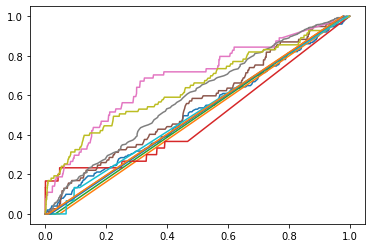

In [ ]:
# Validataion performance
dataset, y_pred = util.get_prediction(
    saved_file=config["save_model_file"], 
    data_type="val"
)
sensitivity_specificity_curves = util.get_sensitivity_specificity_curves(
    truth=dataset.y, pred=y_pred
)
plt.plot(1-sensitivity_specificity_curves[..., 1].T, sensitivity_specificity_curves[..., 0].T)

print("Validataion AUC for each category")
auc = np.trapz(x=1-sensitivity_specificity_curves[..., 1], y=sensitivity_specificity_curves[..., 0], axis=1)
print(auc)
print("Validataion AUC mean")
print(auc.mean())

## MLP with weight decay regularization

In [ ]:
config = {
    "device": 'cuda' if torch.cuda.is_available() else 'cpu',
    "model_class": MLP, 
    "model_kwargs": dict(
        in_features = 12*1000, #np.prod(X_shape),
        out_features = 12, # np.prod(y_shape),
        hidden=1024
    ),
    "X_type": torch.float32, 
    "y_type": torch.float32,
    "data_file": file,
    "data_train_key": "train",
    "data_val_key": "val",
    "data_test_key": "test",
    "train_batch_size": 128,
    "train_epoches": 10,
    "train_loss_class": nn.BCELoss,
    "train_optimizer_class": torch.optim.Adam,
    "train_optimizer_kwargs": dict(
        lr=1e-3,
        weight_decay=1e-4
    ),
    "train_print_interval": 10, 
    "save_model_file": f"model_mlp_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.pt"
}
pprint.PrettyPrinter().pprint(config)
train_results = util.train(config)

{'X_type': torch.float32,
 'data_file': PosixPath('drive/MyDrive/CSC2516_PTBXL/data/ptbxl/export/rhythm.npz'),
 'data_test_key': 'test',
 'data_train_key': 'train',
 'data_val_key': 'val',
 'device': 'cuda',
 'model_class': <class '__main__.MLP'>,
 'model_kwargs': {'hidden': 1024, 'in_features': 12000, 'out_features': 12},
 'save_model_file': 'model_mlp_20210417_183934.pt',
 'train_batch_size': 128,
 'train_epoches': 10,
 'train_loss_class': <class 'torch.nn.modules.loss.BCELoss'>,
 'train_optimizer_class': <class 'torch.optim.adam.Adam'>,
 'train_optimizer_kwargs': {'lr': 0.001, 'weight_decay': 0.0001},
 'train_print_interval': 10,
 'y_type': torch.float32}
Starting training 2021-04-17 18:39:34.556099
[1,     1] loss: 0.700, AUC: [0.66770833 0.98031496        nan 0.91431452        nan 0.31733333
 0.53326613 0.46446602 0.35284553        nan        nan        nan]
[1,    11] loss: 0.355, AUC: [0.48178002        nan        nan        nan        nan 0.47750305
 0.62751385 0.47755526 0.514

No handles with labels found to put in legend.


drive/MyDrive/CSC2516_PTBXL/model_mlp_20210417_183122.pt train AUC for each category
[0.99070497 0.99835958 0.98721128 0.99572955 0.99857127 0.9892896
 0.99699823 0.98804354 0.99761197 0.99772669 0.91900688 0.96080109]
drive/MyDrive/CSC2516_PTBXL/model_mlp_20210417_183122.pt train AUC mean
0.9850045552084086


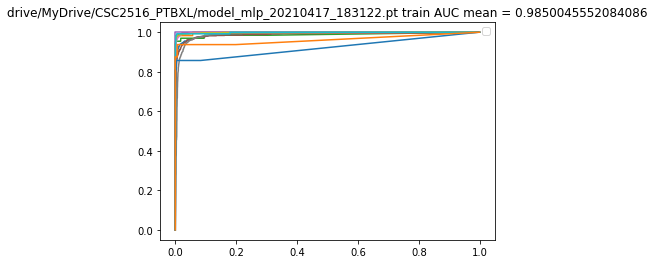

In [ ]:
get_performance("drive/MyDrive/CSC2516_PTBXL/model_mlp_20210417_183122.pt", data_type="train")

No handles with labels found to put in legend.


drive/MyDrive/CSC2516_PTBXL/model_mlp_20210417_183122.pt val AUC for each category
[0.63772501 0.42904717 0.4559436  0.64361873 0.55151947 0.55012335
 0.85150902 0.70661612 0.76274991 0.57714104 0.45916429 0.61687233]
drive/MyDrive/CSC2516_PTBXL/model_mlp_20210417_183122.pt val AUC mean
0.6035025026219724


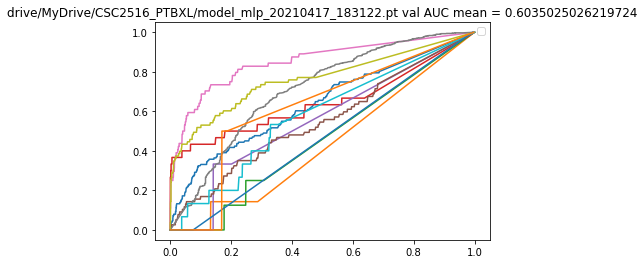

In [ ]:
get_performance("drive/MyDrive/CSC2516_PTBXL/model_mlp_20210417_183122.pt", data_type="val")

No handles with labels found to put in legend.


drive/MyDrive/CSC2516_PTBXL/model_mlp_20210417_183122.pt test AUC for each category
[0.60346246 0.59252317 0.349642   0.65075816 0.40076154 0.50136537
 0.77619621 0.69485943 0.80288676 0.71741435 0.45690476 0.40575916]
drive/MyDrive/CSC2516_PTBXL/model_mlp_20210417_183122.pt test AUC mean
0.5793777808185632


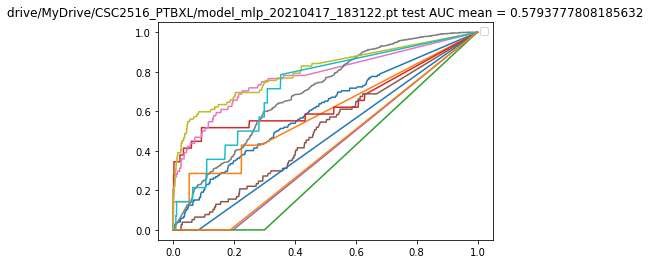

In [ ]:
get_performance("drive/MyDrive/CSC2516_PTBXL/model_mlp_20210417_183122.pt", data_type="test")

### FSGM

FGSM attacking val set
Generating:0/2109
Generating:1000/2109
Generating:2000/2109
val AUC for each category
[0.14523706 0.28211227 0.30985245 0.38885682 0.32716049 0.13254487
 0.42853377 0.10282308 0.3711896  0.24952245 0.40574549 0.37897485]
val AUC mean
0.29354609965977096
FGSM attacking test set
Generating:0/2103
Generating:1000/2103
Generating:2000/2103
test AUC for each category
[0.12289582 0.38365594 0.31527446 0.40451568 0.33460257 0.1180049
 0.35816807 0.10366893 0.3744524  0.32265951 0.40309524 0.38196097]
test AUC mean
0.30191287354991864
FGSM attacking train set
Generating:0/16854
Generating:1000/16854
Generating:2000/16854
Generating:3000/16854
Generating:4000/16854
Generating:5000/16854
Generating:6000/16854
Generating:7000/16854
Generating:8000/16854
Generating:9000/16854
Generating:10000/16854
Generating:11000/16854
Generating:12000/16854
Generating:13000/16854
Generating:14000/16854
Generating:15000/16854
Generating:16000/16854
train AUC for each category
[0.51142709 0

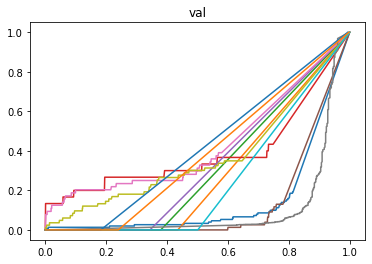

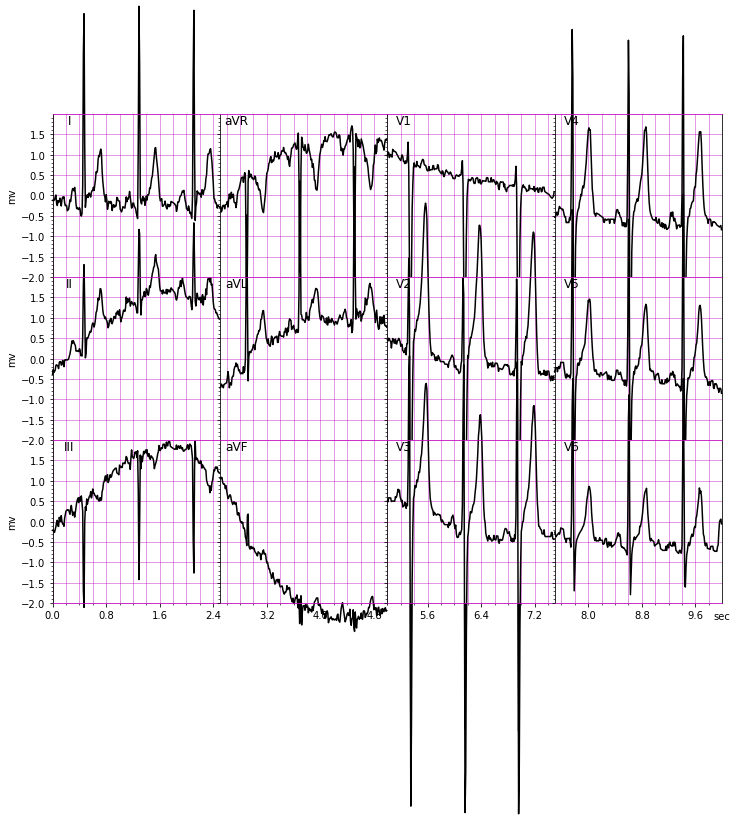

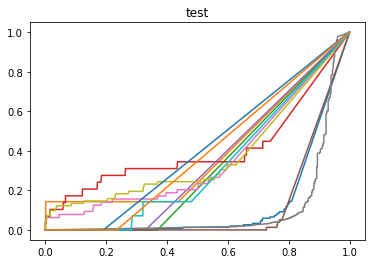

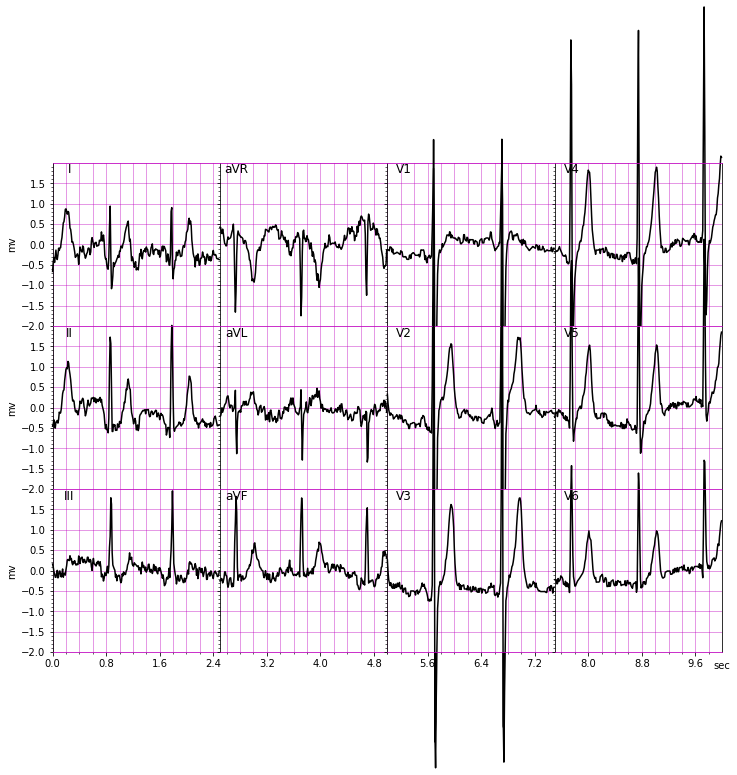

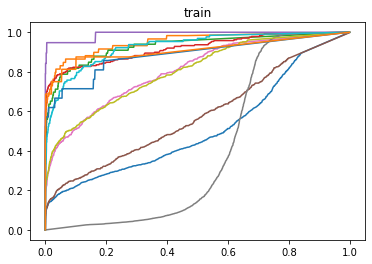

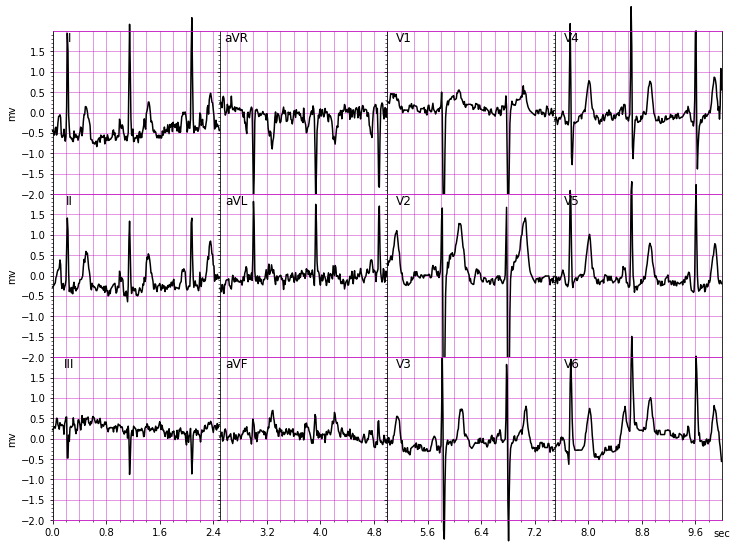

In [ ]:
for data_type in ("val", "test", "train"):
    print(f"FGSM attacking {data_type} set")
    print("======================")
    examples = FGSM.generate_examples(
            saved_file="drive/MyDrive/CSC2516_PTBXL/model_mlp_20210417_183122.pt",
            dataset_file=file,
            data_type = data_type,
            device = "cuda",
            epsilon = 0.05
        )
    # Performance post-attack
    dataset = util.PTBXLDataset(file=file, X=examples, data_type=data_type)
    dataset, y_pred = util.get_prediction(
        saved_file="drive/MyDrive/CSC2516_PTBXL/model_mlp_20210417_183122.pt", 
        dataset=dataset
    )
    sensitivity_specificity_curves = util.get_sensitivity_specificity_curves(
        truth=dataset.y, pred=y_pred
    )
    fig, ax = plt.subplots()
    ax.plot(1-sensitivity_specificity_curves[..., 1].T, sensitivity_specificity_curves[..., 0].T)
    ax.set_title(f"{data_type}")

    print(f"{data_type} AUC for each category")
    auc = np.trapz(x=1-sensitivity_specificity_curves[..., 1], y=sensitivity_specificity_curves[..., 0], axis=1)
    print(auc)
    print(f"{data_type} AUC mean")
    print(auc.mean())
    util.plot_ecg(dataset.X[0, ...])

### SAP

SAP attacking val set
*************
sizes: (5, 7, 11, 15, 19)
sigmas: (1.0, 3.0, 5.0, 7.0, 10.0)
eps = 0.5
step_alpha = 0.02
num_steps = 20
Generating examples for batch 0
Generating examples for batch 1
Generating examples for batch 2
Generating examples for batch 3
Generating examples for batch 4
val AUC for each category
[0.05388151 0.41841104 0.46073298 0.24309764 0.41001899 0.0738189
 0.20209734 0.01657177 0.26924975 0.31303725 0.48076923 0.49145705]
val AUC mean
0.2860952880208438
SAP attacking test set
Loading file = drive/MyDrive/CSC2516_PTBXL/data/ptbxl/export/rhythm.npz key = X_test
Loading file = drive/MyDrive/CSC2516_PTBXL/data/ptbxl/export/rhythm.npz key = y_test
*************
sizes: (5, 7, 11, 15, 19)
sigmas: (1.0, 3.0, 5.0, 7.0, 10.0)
eps = 0.5
step_alpha = 0.02
num_steps = 20
Generating examples for batch 0
Generating examples for batch 1
Generating examples for batch 2
Generating examples for batch 3
Generating examples for batch 4
test AUC for each category
[0.0507432

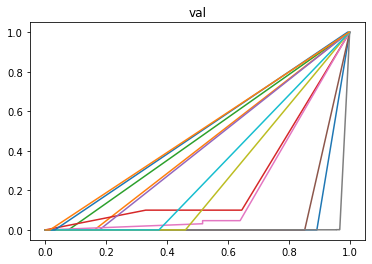

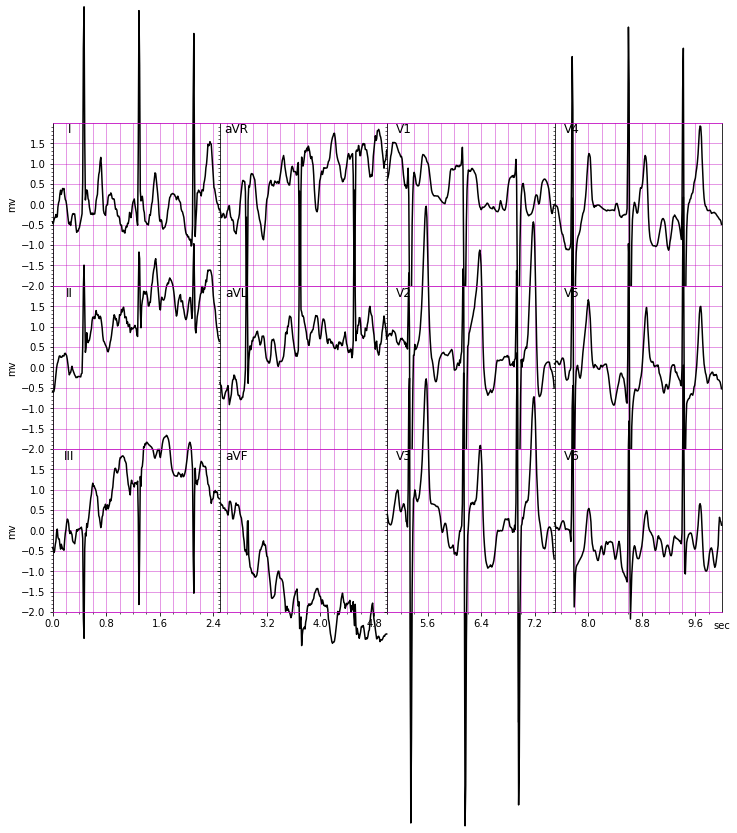

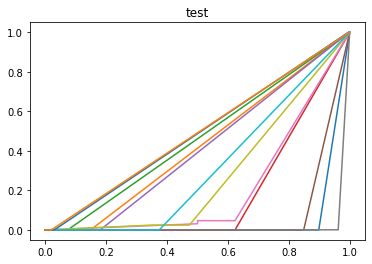

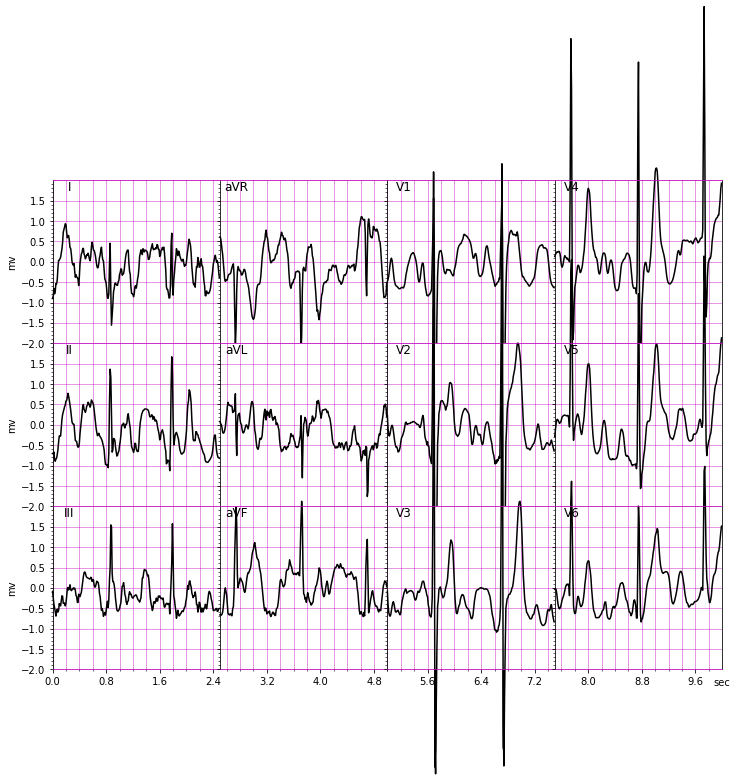

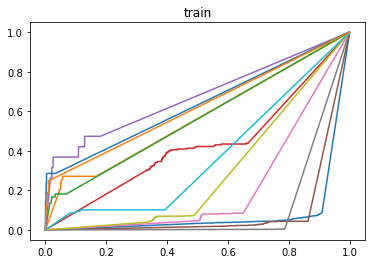

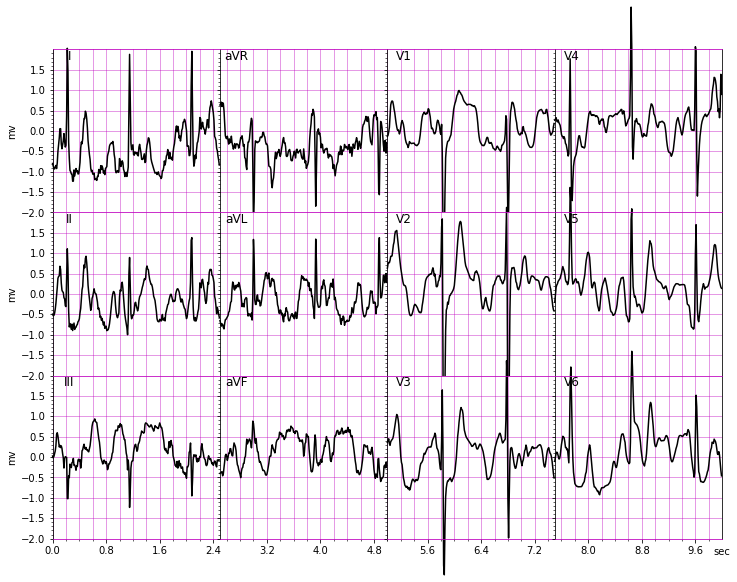

In [ ]:
for data_type in ("val", "test", "train"):
    print(f"SAP attacking {data_type} set")
    print("======================")
    examples = SAP.generate_examples(
            saved_file="drive/MyDrive/CSC2516_PTBXL/model_mlp_20210417_183122.pt",
            dataset_file=file,
            data_type = data_type,
            device = "cuda"
        )
    # Performance post-attack
    dataset = util.PTBXLDataset(file=file, X=examples, data_type=data_type)
    dataset, y_pred = util.get_prediction(
        saved_file="drive/MyDrive/CSC2516_PTBXL/model_mlp_20210417_183122.pt", 
        dataset=dataset
    )
    sensitivity_specificity_curves = util.get_sensitivity_specificity_curves(
        truth=dataset.y, pred=y_pred
    )
    fig, ax = plt.subplots()
    ax.plot(1-sensitivity_specificity_curves[..., 1].T, sensitivity_specificity_curves[..., 0].T)
    ax.set_title(f"{data_type}")

    print(f"{data_type} AUC for each category")
    auc = np.trapz(x=1-sensitivity_specificity_curves[..., 1], y=sensitivity_specificity_curves[..., 0], axis=1)
    print(auc)
    print(f"{data_type} AUC mean")
    print(auc.mean())
    util.plot_ecg(dataset.X[0, ...])

SAP attacking train set
Loading file = drive/MyDrive/CSC2516_PTBXL/data/ptbxl/export/rhythm.npz key = X_train
Loading file = drive/MyDrive/CSC2516_PTBXL/data/ptbxl/export/rhythm.npz key = y_train
*************
sizes: (5, 7, 11, 15, 19)
sigmas: (1.0, 3.0, 5.0, 7.0, 10.0)
eps = 0.5
step_alpha = 0.02
num_steps = 20
Generating examples for batch 0
Generating examples for batch 1
Generating examples for batch 2
Generating examples for batch 3
Generating examples for batch 4
Generating examples for batch 5
Generating examples for batch 6
Generating examples for batch 7
Generating examples for batch 8
Generating examples for batch 9
Generating examples for batch 10
Generating examples for batch 11
Generating examples for batch 12
Generating examples for batch 13
Generating examples for batch 14
Generating examples for batch 15
Generating examples for batch 16
Generating examples for batch 17
Generating examples for batch 18
Generating examples for batch 19
Generating examples for batch 20
Gen

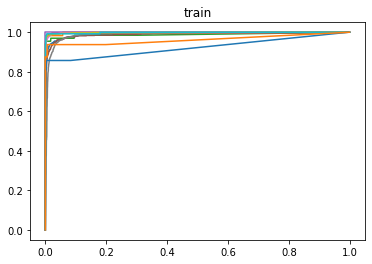

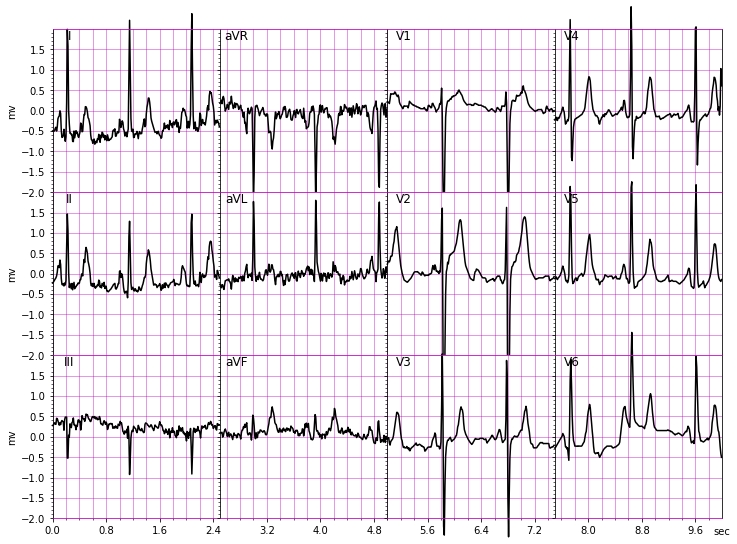

In [ ]:
for data_type in ("train",):
    print(f"SAP attacking {data_type} set")
    print("======================")
    examples = SAP.generate_examples(
            saved_file="drive/MyDrive/CSC2516_PTBXL/model_mlp_20210417_183122.pt",
            dataset_file=file,
            data_type = data_type,
            device = "cuda"
        )
    # Performance post-attack
    dataset = util.PTBXLDataset(file=file, X=examples, data_type=data_type)
    dataset, y_pred = util.get_prediction(
        saved_file="drive/MyDrive/CSC2516_PTBXL/model_mlp_20210417_183122.pt", 
        dataset=dataset
    )
    sensitivity_specificity_curves = util.get_sensitivity_specificity_curves(
        truth=dataset.y, pred=y_pred
    )
    fig, ax = plt.subplots()
    ax.plot(1-sensitivity_specificity_curves[..., 1].T, sensitivity_specificity_curves[..., 0].T)
    ax.set_title(f"{data_type}")

    print(f"{data_type} AUC for each category")
    auc = np.trapz(x=1-sensitivity_specificity_curves[..., 1], y=sensitivity_specificity_curves[..., 0], axis=1)
    print(auc)
    print(f"{data_type} AUC mean")
    print(auc.mean())
    util.plot_ecg(dataset.X[0, ...])

## CNN

In [ ]:
config = {
    "device": 'cuda' if torch.cuda.is_available() else 'cpu',
    "model_class": CNN, 
    "model_kwargs": dict(
        channels=(512, 256), 
        kernel_size=10, 
        hidden_size=512,
        verbose=True
    ),
    "X_type": torch.float32, 
    "y_type": torch.float32,
    "data_file": file,
    "data_train_key": "train",
    "data_val_key": "val",
    "data_test_key": "test",
    "train_batch_size": 256,
    "train_epoches": 10,
    "train_loss_class": nn.BCELoss,
    "train_optimizer_class": torch.optim.Adam,
    "train_optimizer_kwargs": dict(
        lr=1e-3,
        weight_decay=0
    ),
    "train_print_interval": 10, 
    "save_model_file": f"model_cnn_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.pt"
}
pprint.PrettyPrinter().pprint(config)
train_results = util.train(config)


{'X_type': torch.float32,
 'data_file': PosixPath('drive/MyDrive/CSC2516_PTBXL/data/ptbxl/export/rhythm.npz'),
 'data_test_key': 'test',
 'data_train_key': 'train',
 'data_val_key': 'val',
 'device': 'cuda',
 'model_class': <class '__main__.CNN'>,
 'model_kwargs': {'channels': (512, 256),
                  'hidden_size': 512,
                  'kernel_size': 10,
                  'verbose': True},
 'save_model_file': 'model_cnn_20210417_191141.pt',
 'train_batch_size': 256,
 'train_epoches': 10,
 'train_loss_class': <class 'torch.nn.modules.loss.BCELoss'>,
 'train_optimizer_class': <class 'torch.optim.adam.Adam'>,
 'train_optimizer_kwargs': {'lr': 0.001, 'weight_decay': 0},
 'train_print_interval': 10,
 'y_type': torch.float32}
CNN block output shape = torch.Size([1, 256, 9])
Starting training 2021-04-17 19:11:41.146329
[1,     1] loss: 0.697, AUC: [0.47382812        nan 0.75490196 0.16121032 0.81568627 0.4652439
 0.58107607 0.50548378 0.42918347 0.4507874  0.61960784        nan]
[1,  

CNN block output shape = torch.Size([1, 256, 9])


No handles with labels found to put in legend.


model_cnn_20210417_191141.pt train AUC for each category
[0.99820444 0.99243772 0.98707275 0.99875579 0.99494631 0.85967168
 0.98258577 0.95403371 0.99845103 0.95049857 0.99742711 0.98651673]
model_cnn_20210417_191141.pt train AUC mean
0.9750501338231047


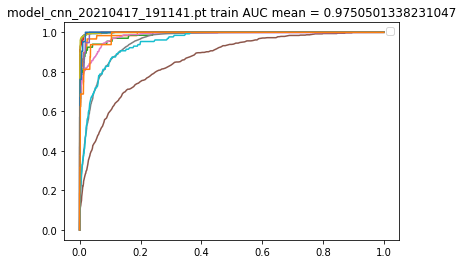

In [ ]:
get_performance(config["save_model_file"], "train")

CNN block output shape = torch.Size([1, 256, 9])


No handles with labels found to put in legend.


model_cnn_20210417_191141.pt val AUC for each category
[0.99123311 0.97057224 0.99164089 0.9524531  0.99778411 0.76581194
 0.97771623 0.92650902 0.9945795  0.90425024 0.99176955 0.9744898 ]
model_cnn_20210417_191141.pt val AUC mean
0.9532341442756604


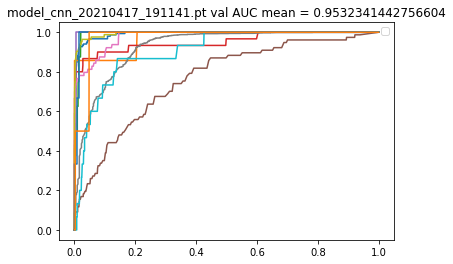

In [ ]:
get_performance(config["save_model_file"], "val")

CNN block output shape = torch.Size([1, 256, 9])


No handles with labels found to put in legend.


model_cnn_20210417_191141.pt test AUC for each category
[0.98361164 0.88457606 0.85912888 0.93692847 0.99833413 0.74251292
 0.95588754 0.90256047 0.98905697 0.86314368 0.99650794 0.9671585 ]
model_cnn_20210417_191141.pt test AUC mean
0.9232839329110983


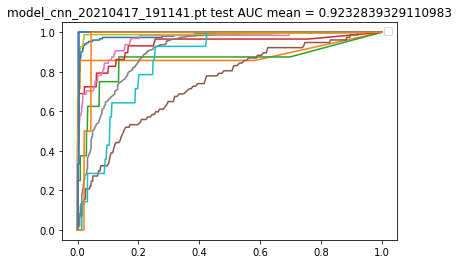

In [ ]:
get_performance(config["save_model_file"], "test")

### FGSM attack eps=0.05

FGSM attacking val set
eps = 0.05
CNN block output shape = torch.Size([1, 256, 9])
Loading file = drive/MyDrive/CSC2516_PTBXL/data/ptbxl/export/rhythm.npz key = X_val
Loading file = drive/MyDrive/CSC2516_PTBXL/data/ptbxl/export/rhythm.npz key = y_val
Generating:0/2109
Generating:1000/2109
Generating:2000/2109
CNN block output shape = torch.Size([1, 256, 9])
val AUC for each category
[0.93145966 0.94749898 0.97554736 0.90511464 0.997151   0.46546809
 0.96173976 0.78095816 0.98946824 0.64489016 0.99058246 0.85809207]
val AUC mean
0.8706642158295222
FGSM attacking test set
eps = 0.05
CNN block output shape = torch.Size([1, 256, 9])
Loading file = drive/MyDrive/CSC2516_PTBXL/data/ptbxl/export/rhythm.npz key = X_test
Loading file = drive/MyDrive/CSC2516_PTBXL/data/ptbxl/export/rhythm.npz key = y_test
Generating:0/2103
Generating:1000/2103
Generating:2000/2103
CNN block output shape = torch.Size([1, 256, 9])
test AUC for each category
[0.91709717 0.86620774 0.80286396 0.87989226 0.99809614 0

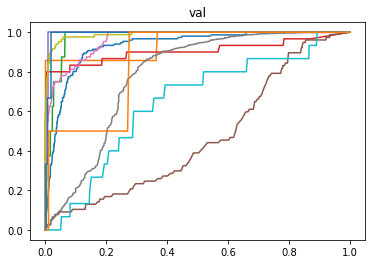

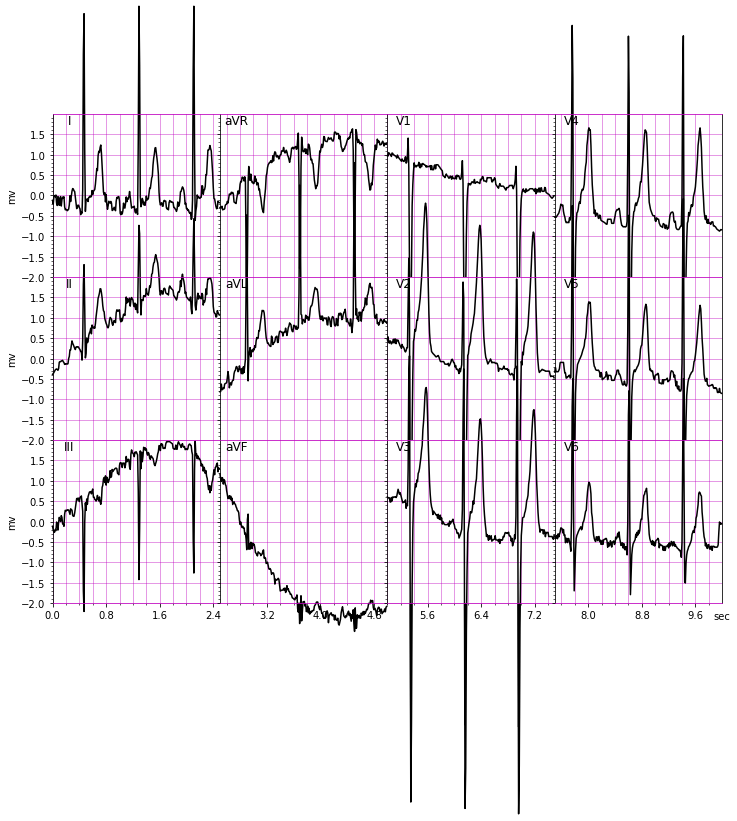

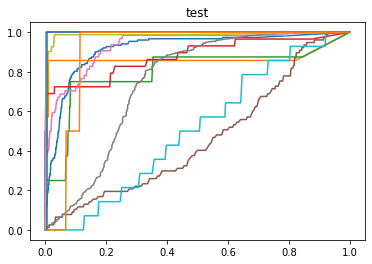

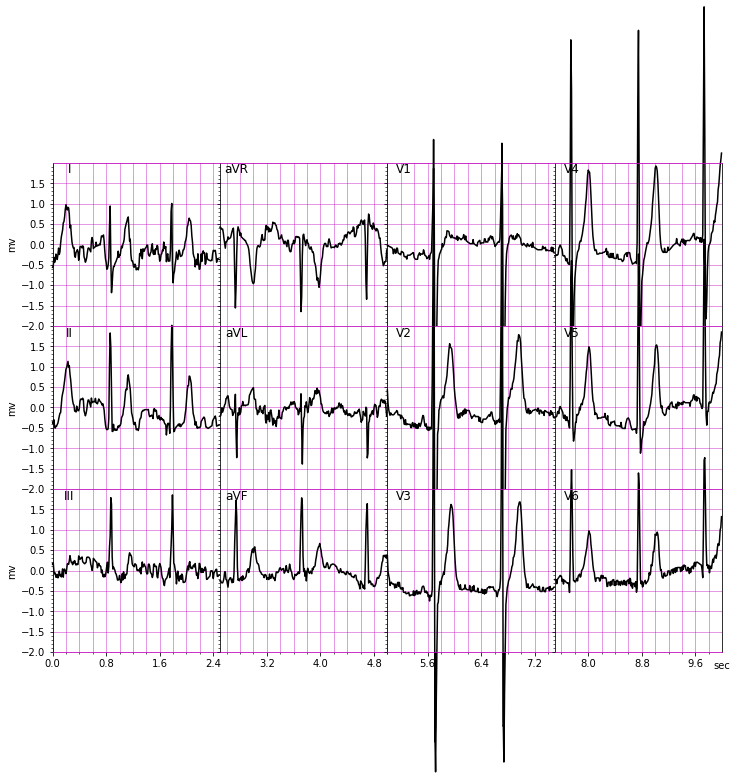

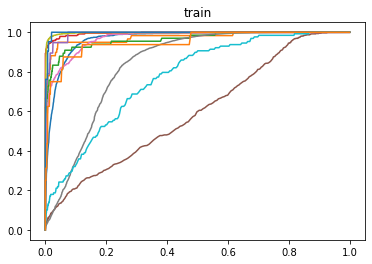

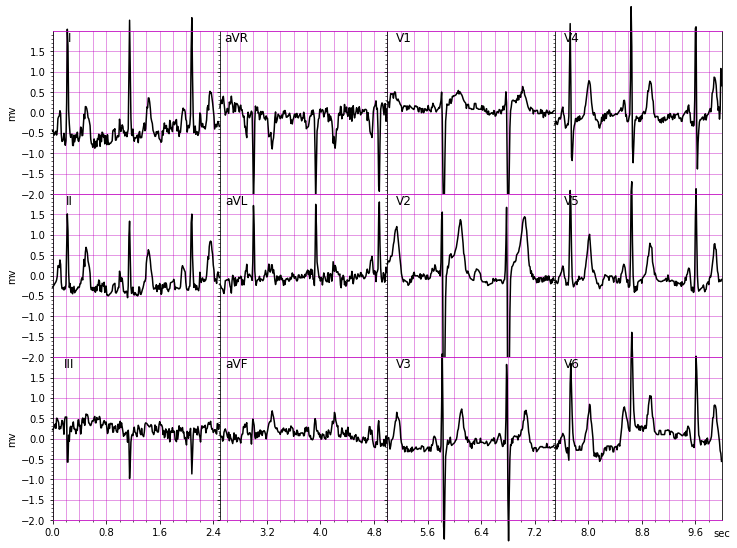

In [ ]:
for data_type in ("val", "test", "train"):
    print(f"FGSM attacking {data_type} set")
    eps = 0.05
    print(f"eps = {eps}")
    print("======================")
    examples = FGSM.generate_examples(
            saved_file="drive/MyDrive/CSC2516_PTBXL/model_cnn_20210417_191141.pt",
            dataset_file=file,
            data_type = data_type,
            device = "cuda",
            epsilon = eps
        )
    # Performance post-attack
    dataset = util.PTBXLDataset(file=file, X=examples, data_type=data_type)
    dataset, y_pred = util.get_prediction(
        saved_file="drive/MyDrive/CSC2516_PTBXL/model_cnn_20210417_191141.pt", 
        dataset=dataset
    )
    sensitivity_specificity_curves = util.get_sensitivity_specificity_curves(
        truth=dataset.y, pred=y_pred
    )
    fig, ax = plt.subplots()
    ax.plot(1-sensitivity_specificity_curves[..., 1].T, sensitivity_specificity_curves[..., 0].T)
    ax.set_title(f"{data_type}")

    print(f"{data_type} AUC for each category")
    auc = np.trapz(x=1-sensitivity_specificity_curves[..., 1], y=sensitivity_specificity_curves[..., 0], axis=1)
    print(auc)
    print(f"{data_type} AUC mean")
    print(auc.mean())
    util.plot_ecg(dataset.X[0, ...])

### SAP

SAP attacking val set
CNN block output shape = torch.Size([1, 256, 9])
Loading file = drive/MyDrive/CSC2516_PTBXL/data/ptbxl/export/rhythm.npz key = X_val
Loading file = drive/MyDrive/CSC2516_PTBXL/data/ptbxl/export/rhythm.npz key = y_val
*************
sizes: (5, 7, 11, 15, 19)
sigmas: (1.0, 3.0, 5.0, 7.0, 10.0)
eps = 0.5
step_alpha = 0.02
num_steps = 20
Generating examples for batch 0
Generating examples for batch 1
Generating examples for batch 2
Generating examples for batch 3
Generating examples for batch 4
CNN block output shape = torch.Size([1, 256, 9])
val AUC for each category
[0.25015389 0.83536088 0.39951214 0.69033991 0.86245647 0.42563146
 0.5596004  0.15114806 0.67204058 0.28616683 0.82684394 0.35524442]
val AUC mean
0.5262082480183785
SAP attacking test set
CNN block output shape = torch.Size([1, 256, 9])
Loading file = drive/MyDrive/CSC2516_PTBXL/data/ptbxl/export/rhythm.npz key = X_test
Loading file = drive/MyDrive/CSC2516_PTBXL/data/ptbxl/export/rhythm.npz key = y_test

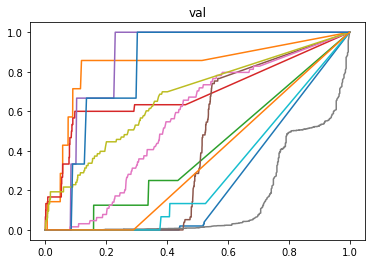

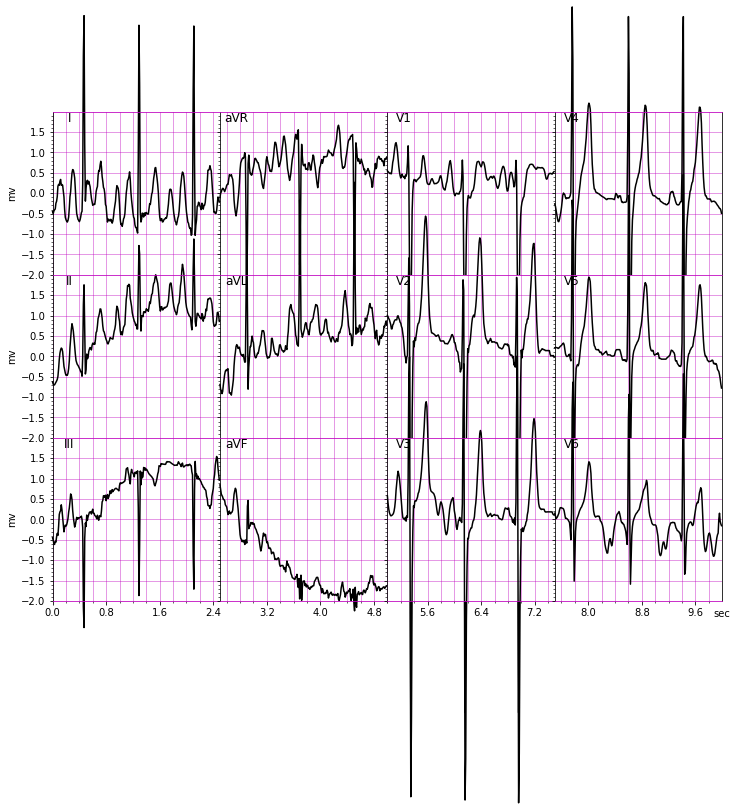

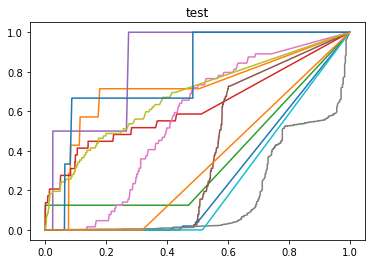

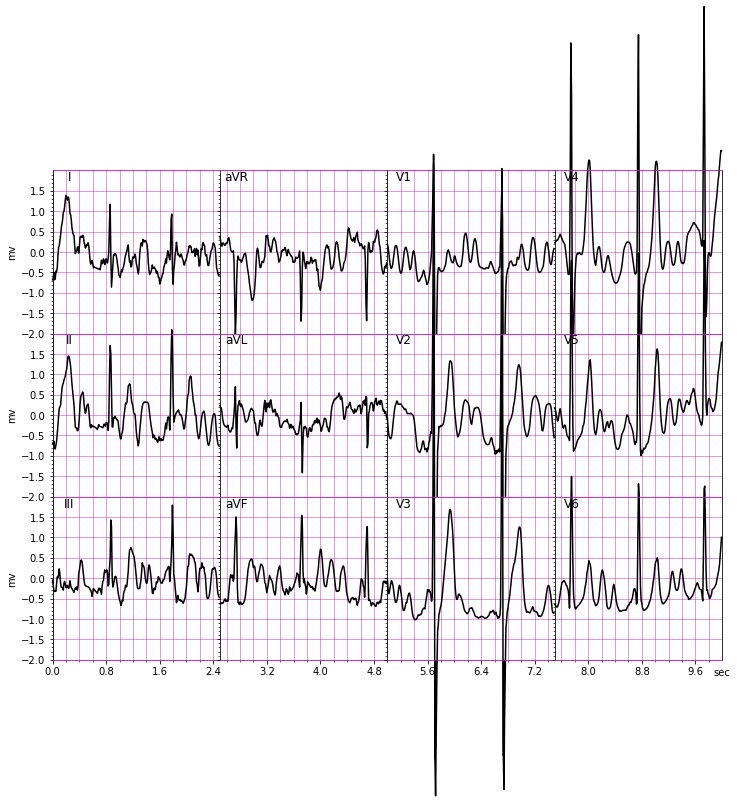

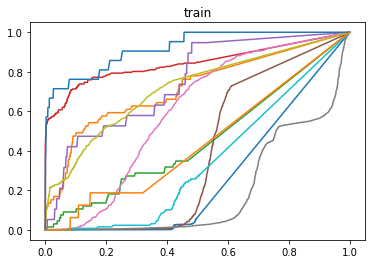

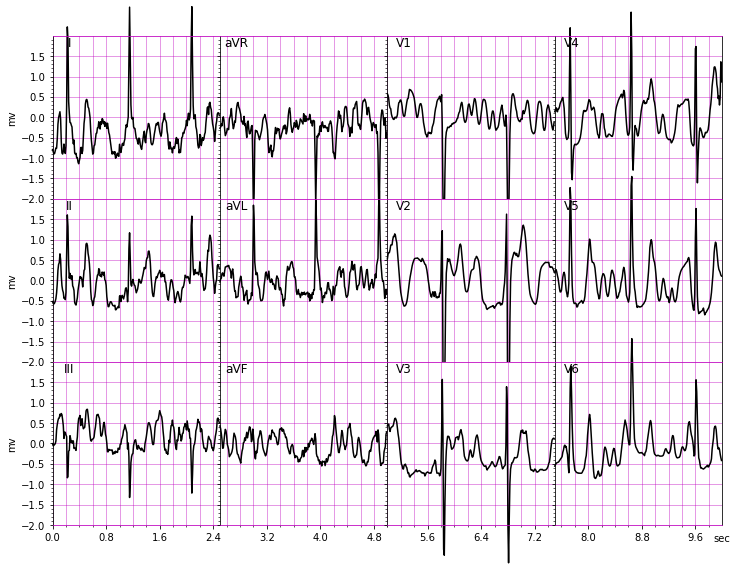

In [ ]:
for data_type in ("val", "test", "train"):
    print(f"SAP attacking {data_type} set")
    print("======================")
    examples = SAP.generate_examples(
            saved_file="drive/MyDrive/CSC2516_PTBXL/model_cnn_20210417_191141.pt",
            dataset_file=file,
            data_type = data_type,
            device = "cuda"
        )
    assert examples is not None
    # Performance post-attack
    dataset = util.PTBXLDataset(file=file, X=examples, data_type=data_type)
    dataset, y_pred = util.get_prediction(
        saved_file="drive/MyDrive/CSC2516_PTBXL/model_cnn_20210417_191141.pt", 
        dataset=dataset
    )
    sensitivity_specificity_curves = util.get_sensitivity_specificity_curves(
        truth=dataset.y, pred=y_pred
    )
    fig, ax = plt.subplots()
    ax.plot(1-sensitivity_specificity_curves[..., 1].T, sensitivity_specificity_curves[..., 0].T)
    ax.set_title(f"{data_type}")

    print(f"{data_type} AUC for each category")
    auc = np.trapz(x=1-sensitivity_specificity_curves[..., 1], y=sensitivity_specificity_curves[..., 0], axis=1)
    print(auc)
    print(f"{data_type} AUC mean")
    print(auc.mean())
    util.plot_ecg(dataset.X[0, ...])

## LSTM

In [ ]:


config = {
    "device": 'cuda' if torch.cuda.is_available() else 'cpu',
    "model_class": LSTM1, 
    "model_kwargs": dict(
        input_channels=12, # X.shape[-1],
        output_channels=12, # y.shape[-1],
        seq_length=1000, # X.shape[1],
        hidden_dim=4,
        num_layers=2,
        mlp_hidden_size=256
    ),
    "X_type": torch.float32, 
    "y_type": torch.float32,
    "data_file": file,
    "data_train_key": "train",
    "data_val_key": "val",
    "data_test_key": "test",
    "train_batch_size": 32,
    "train_epoches": 10,
    "train_loss_class": nn.BCELoss,
    "train_optimizer_class": torch.optim.Adam,
    "train_optimizer_kwargs": dict(
        lr=1e-3,
        weight_decay=0
    ),
    "train_print_interval": 10, 
    "save_model_file": f"model_lstm_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.pt"
}
pprint.PrettyPrinter().pprint(config)
train_results = util.train(config)


{'X_type': torch.float32,
 'data_file': PosixPath('drive/MyDrive/CSC2516_PTBXL/data/ptbxl/export/rhythm.npz'),
 'data_test_key': 'test',
 'data_train_key': 'train',
 'data_val_key': 'val',
 'device': 'cuda',
 'model_class': <class '__main__.LSTM1'>,
 'model_kwargs': {'hidden_dim': 4,
                  'input_channels': 12,
                  'mlp_hidden_size': 256,
                  'num_layers': 2,
                  'output_channels': 12,
                  'seq_length': 1000},
 'save_model_file': 'model_lstm_20210417_164439.pt',
 'train_batch_size': 32,
 'train_epoches': 10,
 'train_loss_class': <class 'torch.nn.modules.loss.BCELoss'>,
 'train_optimizer_class': <class 'torch.optim.adam.Adam'>,
 'train_optimizer_kwargs': {'lr': 0.001, 'weight_decay': 0},
 'train_print_interval': 10,
 'y_type': torch.float32}
Starting training 2021-04-17 16:44:39.709804
[1,     1] loss: 0.700, AUC: [0.44814815        nan        nan        nan        nan        nan
 0.62903226 0.62239583 0.31666667       

### Performance

#### Notes




---


This model is overfitting...
```
{'X_type': torch.float32,
 'data_file': PosixPath('drive/MyDrive/CSC2516_PTBXL/data/ptbxl/export/rhythm.npz'),
 'data_test_key': 'test',
 'data_train_key': 'train',
 'data_val_key': 'val',
 'device': 'cuda',
 'model_class': <class '__main__.LSTM1'>,
 'model_kwargs': {'hidden_dim': 128,
                  'input_channels': 12,
                  'mlp_hidden_size': 256,
                  'num_layers': 2,
                  'output_channels': 12,
                  'seq_length': 1000},
 'save_model_file': 'model_lstm_20210417_152755.pt',
 'train_batch_size': 512,
 'train_epoches': 10,
 'train_loss_class': <class 'torch.nn.modules.loss.BCELoss'>,
 'train_optimizer_class': <class 'torch.optim.adam.Adam'>,
 'train_optimizer_kwargs': {'lr': 0.001, 'weight_decay': 0},
 'train_print_interval': 10,
 'y_type': torch.float32}
 ```
drive/MyDrive/CSC2516_PTBXL/model_lstm_20210417_151748.pt train AUC for each category
[0.99972904 0.99994046 0.99915885 0.99993982 0.9999406  0.99963847
 0.99981556 0.99946061 0.99989162 0.99982064 0.99970296 1.        ]
drive/MyDrive/CSC2516_PTBXL/model_lstm_20210417_151748.pt train AUC mean
0.9997532198204048

drive/MyDrive/CSC2516_PTBXL/model_lstm_20210417_151748.pt val AUC for each category
[0.81252664 0.89061438 0.70100547 0.79315376 0.64007597 0.5781266
 0.88323655 0.77957545 0.91411649 0.65557147 0.47981956 0.45111533]
drive/MyDrive/CSC2516_PTBXL/model_lstm_20210417_151748.pt val AUC mean
0.7149114732790167

---

```
{'X_type': torch.float32,
 'data_file': PosixPath('drive/MyDrive/CSC2516_PTBXL/data/ptbxl/export/rhythm.npz'),
 'data_test_key': 'test',
 'data_train_key': 'train',
 'data_val_key': 'val',
 'device': 'cuda',
 'model_class': <class '__main__.LSTM1'>,
 'model_kwargs': {'hidden_dim': 128,
                  'input_channels': 12,
                  'mlp_hidden_size': 16,
                  'num_layers': 2,
                  'output_channels': 12,
                  'seq_length': 1000},
 'save_model_file': 'model_lstm_20210417_155756.pt',
 'train_batch_size': 128,
 'train_epoches': 10,
 'train_loss_class': <class 'torch.nn.modules.loss.BCELoss'>,
 'train_optimizer_class': <class 'torch.optim.adam.Adam'>,
 'train_optimizer_kwargs': {'lr': 0.0001, 'weight_decay': 0},
 'train_print_interval': 10,
 'y_type': torch.float32}
```
drive/MyDrive/CSC2516_PTBXL/model_lstm_20210417_155756.pt train AUC for each category
[0.90614687 0.92634965 0.68378974 0.96460643 0.43959483 0.78258301
 0.9642581  0.86071575 0.95994557 0.69420387 0.90158362 0.70306747]
drive/MyDrive/CSC2516_PTBXL/model_lstm_20210417_155756.pt train AUC mean
0.8155704088095271

drive/MyDrive/CSC2516_PTBXL/model_lstm_20210417_155756.pt val AUC for each category
[0.81720772 0.97169363 0.51222632 0.85363957 0.37068693 0.51849627
 0.87953087 0.76807546 0.91734559 0.6178128  0.66096866 0.84966777]
drive/MyDrive/CSC2516_PTBXL/model_lstm_20210417_155756.pt val AUC mean
0.7281126321313786

----- 


```
{'X_type': torch.float32,
 'data_file': PosixPath('drive/MyDrive/CSC2516_PTBXL/data/ptbxl/export/rhythm.npz'),
 'data_test_key': 'test',
 'data_train_key': 'train',
 'data_val_key': 'val',
 'device': 'cuda',
 'model_class': <class '__main__.LSTM1'>,
 'model_kwargs': {'hidden_dim': 16,
                  'input_channels': 12,
                  'mlp_hidden_size': 256,
                  'num_layers': 2,
                  'output_channels': 12,
                  'seq_length': 1000},
 'save_model_file': 'model_lstm_20210417_161445.pt',
 'train_batch_size': 256,
 'train_epoches': 10,
 'train_loss_class': <class 'torch.nn.modules.loss.BCELoss'>,
 'train_optimizer_class': <class 'torch.optim.adam.Adam'>,
 'train_optimizer_kwargs': {'lr': 0.001, 'weight_decay': 0},
 'train_print_interval': 10,
 'y_type': torch.float32}
 ```



 model_resnet1d_20210417_145517.pt train AUC for each category
[0.9904049  0.95203476 0.92318783 0.97947415 0.96251387 0.78374433
 0.97325666 0.94231519 0.99540976 0.73622887 0.98430945 0.89663447]
model_resnet1d_20210417_145517.pt train AUC mean
0.926626186622638


drive/MyDrive/CSC2516_PTBXL/model_lstm_20210417_161445.pt val AUC for each category
[0.85863565 0.88657061 0.67461923 0.80926728 0.98203545 0.6028799
 0.92720431 0.79709368 0.9226085  0.70031837 0.64252928 0.60121025]
drive/MyDrive/CSC2516_PTBXL/model_lstm_20210417_161445.pt val AUC mean
0.7837477097176738


-----


```
{'X_type': torch.float32,
 'data_file': PosixPath('drive/MyDrive/CSC2516_PTBXL/data/ptbxl/export/rhythm.npz'),
 'data_test_key': 'test',
 'data_train_key': 'train',
 'data_val_key': 'val',
 'device': 'cuda',
 'model_class': <class '__main__.LSTM1'>,
 'model_kwargs': {'hidden_dim': 8,
                  'input_channels': 12,
                  'mlp_hidden_size': 256,
                  'num_layers': 2,
                  'output_channels': 12,
                  'seq_length': 1000},
 'save_model_file': 'model_lstm_20210417_162516.pt',
 'train_batch_size': 256,
 'train_epoches': 10,
 'train_loss_class': <class 'torch.nn.modules.loss.BCELoss'>,
 'train_optimizer_class': <class 'torch.optim.adam.Adam'>,
 'train_optimizer_kwargs': {'lr': 0.001, 'weight_decay': 0},
 'train_print_interval': 10,
 'y_type': torch.float32}
 ```



drive/MyDrive/CSC2516_PTBXL/model_lstm_20210417_162516.pt train AUC for each category
[0.98761486 0.99997729 0.99830462 0.9987097  1.         0.93267752
 0.99250824 0.97426824 0.99955753 0.98847766 1.         0.99998886]
drive/MyDrive/CSC2516_PTBXL/model_lstm_20210417_162516.pt train AUC mean
0.9893403771648154


drive/MyDrive/CSC2516_PTBXL/model_lstm_20210417_162516.pt val AUC for each category
[0.81625222 0.87413348 0.63672061 0.81234568 0.92418487 0.57160433
 0.93288891 0.80519498 0.95979971 0.63793378 0.79969927 0.40377314]
drive/MyDrive/CSC2516_PTBXL/model_lstm_20210417_162516.pt val AUC mean
0.7645442476436672


--------------

```
{'X_type': torch.float32,
 'data_file': PosixPath('drive/MyDrive/CSC2516_PTBXL/data/ptbxl/export/rhythm.npz'),
 'data_test_key': 'test',
 'data_train_key': 'train',
 'data_val_key': 'val',
 'device': 'cuda',
 'model_class': <class '__main__.LSTM1'>,
 'model_kwargs': {'hidden_dim': 4,
                  'input_channels': 12,
                  'mlp_hidden_size': 256,
                  'num_layers': 2,
                  'output_channels': 12,
                  'seq_length': 1000},
 'save_model_file': 'model_lstm_20210417_163400.pt',
 'train_batch_size': 128,
 'train_epoches': 10,
 'train_loss_class': <class 'torch.nn.modules.loss.BCELoss'>,
 'train_optimizer_class': <class 'torch.optim.adam.Adam'>,
 'train_optimizer_kwargs': {'lr': 0.001, 'weight_decay': 0},
 'train_print_interval': 10,
 'y_type': torch.float32}
 ```



 drive/MyDrive/CSC2516_PTBXL/model_lstm_20210417_163400.pt train AUC for each category
[0.96273352 0.99207997 0.9766536  0.99601153 1.         0.85366651
 0.98649064 0.94273825 0.99806452 0.96189036 0.99998586 0.99501685]
drive/MyDrive/CSC2516_PTBXL/model_lstm_20210417_163400.pt train AUC mean
0.9721109678049319




drive/MyDrive/CSC2516_PTBXL/model_lstm_20210417_163400.pt val AUC for each category
[0.82521021 0.89071632 0.76695621 0.85444124 0.96612852 0.53677523
 0.90729294 0.81077282 0.94139143 0.72835084 0.95109212 0.51269578]
drive/MyDrive/CSC2516_PTBXL/model_lstm_20210417_163400.pt val AUC mean
0.8076519723171388




-------------------


```
{'X_type': torch.float32,
 'data_file': PosixPath('drive/MyDrive/CSC2516_PTBXL/data/ptbxl/export/rhythm.npz'),
 'data_test_key': 'test',
 'data_train_key': 'train',
 'data_val_key': 'val',
 'device': 'cuda',
 'model_class': <class '__main__.LSTM1'>,
 'model_kwargs': {'hidden_dim': 4,
                  'input_channels': 12,
                  'mlp_hidden_size': 256,
                  'num_layers': 2,
                  'output_channels': 12,
                  'seq_length': 1000},
 'save_model_file': 'model_lstm_20210417_164439.pt',
 'train_batch_size': 32,
 'train_epoches': 10,
 'train_loss_class': <class 'torch.nn.modules.loss.BCELoss'>,
 'train_optimizer_class': <class 'torch.optim.adam.Adam'>,
 'train_optimizer_kwargs': {'lr': 0.001, 'weight_decay': 0},
 'train_print_interval': 10,
 'y_type': torch.float32}

```


drive/MyDrive/CSC2516_PTBXL/model_lstm_20210417_164439.pt train AUC for each category
[0.99989574 1.         0.99991832 0.99992268 0.9999406  0.99894084
 0.99986694 0.99942958 0.99999991 0.99934211 1.         0.99994061]
drive/MyDrive/CSC2516_PTBXL/model_lstm_20210417_164439.pt train AUC mean
0.999766444277447


drive/MyDrive/CSC2516_PTBXL/model_lstm_20210417_164439.pt val AUC for each category
[0.83257345 0.61563817 0.56615897 0.77246272 0.65954416 0.63628375
 0.92111476 0.83788567 0.94334198 0.5785737  0.48812915 0.71167537]
drive/MyDrive/CSC2516_PTBXL/model_lstm_20210417_164439.pt val AUC mean
0.7136151540625525

#### Code

No handles with labels found to put in legend.


drive/MyDrive/CSC2516_PTBXL/model_lstm_20210417_163400.pt train AUC for each category
[0.96273352 0.99207997 0.9766536  0.99601153 1.         0.85366651
 0.98649064 0.9427395  0.99806452 0.96189036 0.99998586 0.99501685]
drive/MyDrive/CSC2516_PTBXL/model_lstm_20210417_163400.pt train AUC mean
0.9721110719165371


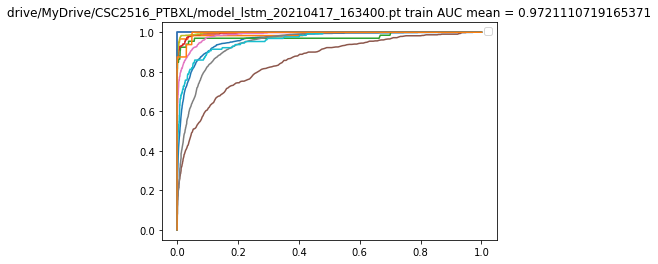

In [ ]:
# get_performance('drive/MyDrive/CSC2516_PTBXL/model_lstm_20210417_151748.pt', data_type="train")
# get_performance('drive/MyDrive/CSC2516_PTBXL/model_lstm_20210417_155756.pt', data_type="train")

# get_performance('drive/MyDrive/CSC2516_PTBXL/model_lstm_20210417_161445.pt', data_type="train")

# get_performance('drive/MyDrive/CSC2516_PTBXL/model_lstm_20210417_162516.pt', data_type="train")


get_performance("drive/MyDrive/CSC2516_PTBXL/model_lstm_20210417_163400.pt", data_type="train")

# get_performance("drive/MyDrive/CSC2516_PTBXL/model_lstm_20210417_164439.pt", data_type="train")

No handles with labels found to put in legend.


drive/MyDrive/CSC2516_PTBXL/model_lstm_20210417_163400.pt val AUC for each category
[0.82521021 0.89071632 0.76695621 0.85444124 0.96612852 0.53677523
 0.90729294 0.81077282 0.94139143 0.72835084 0.95109212 0.51269578]
drive/MyDrive/CSC2516_PTBXL/model_lstm_20210417_163400.pt val AUC mean
0.8076519723171388


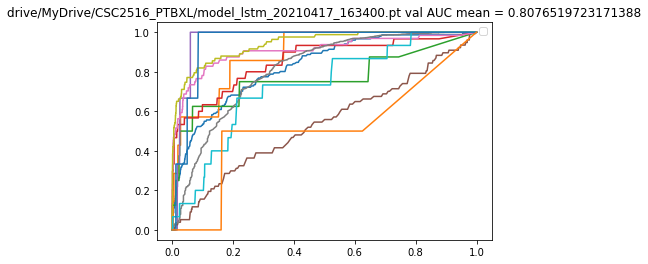

In [ ]:
get_performance("drive/MyDrive/CSC2516_PTBXL/model_lstm_20210417_163400.pt", data_type="val")

Loading file = drive/MyDrive/CSC2516_PTBXL/data/ptbxl/export/rhythm.npz key = X_test
Loading file = drive/MyDrive/CSC2516_PTBXL/data/ptbxl/export/rhythm.npz key = y_test


No handles with labels found to put in legend.


drive/MyDrive/CSC2516_PTBXL/model_lstm_20210417_163400.pt test AUC for each category
[0.8261283  0.73500545 0.7149463  0.86414724 0.8210376  0.47331765
 0.87205738 0.79915586 0.95856012 0.67877658 0.82365079 0.72513089]
drive/MyDrive/CSC2516_PTBXL/model_lstm_20210417_163400.pt test AUC mean
0.7743261811128329


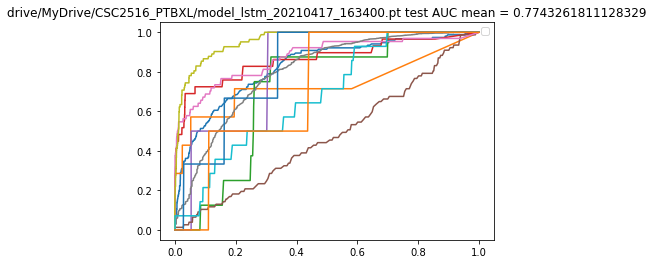

In [ ]:
get_performance("drive/MyDrive/CSC2516_PTBXL/model_lstm_20210417_163400.pt", data_type="test")

### FGSM

In [ ]:
for data_type in ("val", "test", "train"):
    print(f"FGSM attacking {data_type} set")
    print("======================")
    examples = FGSM.generate_examples(
            saved_file="drive/MyDrive/CSC2516_PTBXL/model_lstm_20210417_163400.pt",
            dataset_file=file,
            data_type = data_type,
            device = "cuda",
            epsilon = 0.05
        )
    # Performance post-attack
    dataset = util.PTBXLDataset(file=file, X=examples, data_type=data_type)
    dataset, y_pred = util.get_prediction(
        saved_file="drive/MyDrive/CSC2516_PTBXL/model_lstm_20210417_163400.pt", 
        dataset=dataset
    )
    sensitivity_specificity_curves = util.get_sensitivity_specificity_curves(
        truth=dataset.y, pred=y_pred
    )
    fig, ax = plt.subplots()
    ax.plot(1-sensitivity_specificity_curves[..., 1].T, sensitivity_specificity_curves[..., 0].T)
    ax.set_title(f"{data_type}")

    print(f"{data_type} AUC for each category")
    auc = np.trapz(x=1-sensitivity_specificity_curves[..., 1], y=sensitivity_specificity_curves[..., 0], axis=1)
    print(auc)
    print(f"{data_type} AUC mean")
    print(auc.mean())
    util.plot_ecg(dataset.X[0, ...])

FGSM attacking val set
Generating:0/2109


KeyboardInterrupt: ignored

FGSM attacking train set
Generating:0/16854
Generating:1000/16854
Generating:2000/16854
Generating:3000/16854
Generating:4000/16854
Generating:5000/16854
train AUC for each category
[0.2728776  0.8350652  0.62117972 0.89200625 0.98386397 0.12720361
 0.56496976 0.24339516 0.71149049 0.40546092 0.98570856 0.81268061]
train AUC mean
0.6213251544215772


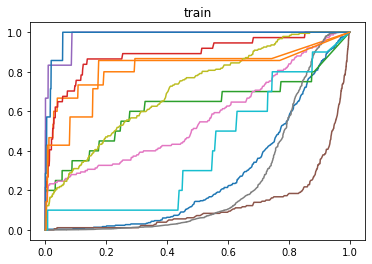

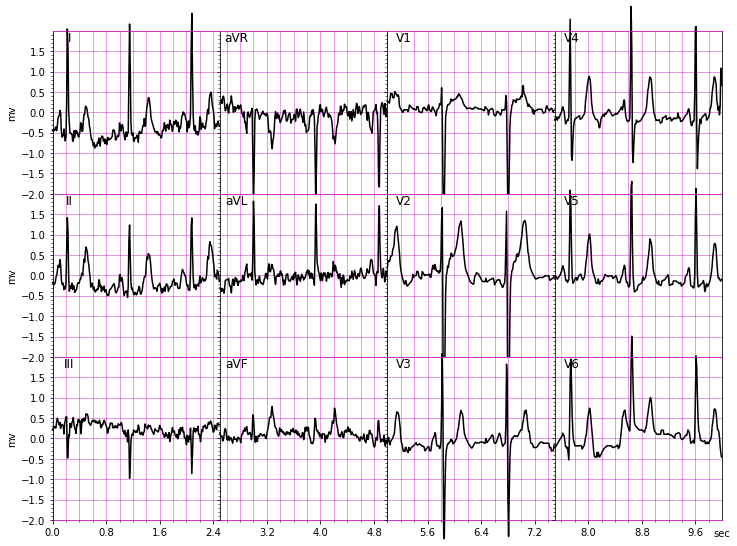

In [ ]:
for data_type in ("train", ):
    print(f"FGSM attacking {data_type} set")
    print("======================")
    examples = FGSM.generate_examples(
            saved_file="drive/MyDrive/CSC2516_PTBXL/model_lstm_20210417_163400.pt",
            dataset_file=file,
            data_type = data_type,
            device = "cuda",
            epsilon = 0.05,
            n = 5000
        )
    # Performance post-attack
    dataset = util.PTBXLDataset(file=file, data_type=data_type)
    dataset = util.PTBXLDataset(file=file, X=examples, y=dataset.y[0:len(examples), ...])
    dataset, y_pred = util.get_prediction(
        saved_file="drive/MyDrive/CSC2516_PTBXL/model_lstm_20210417_163400.pt", 
        dataset=dataset
    )
    sensitivity_specificity_curves = util.get_sensitivity_specificity_curves(
        truth=dataset.y, pred=y_pred
    )
    fig, ax = plt.subplots()
    ax.plot(1-sensitivity_specificity_curves[..., 1].T, sensitivity_specificity_curves[..., 0].T)
    ax.set_title(f"{data_type}")

    print(f"{data_type} AUC for each category")
    auc = np.trapz(x=1-sensitivity_specificity_curves[..., 1], y=sensitivity_specificity_curves[..., 0], axis=1)
    print(auc)
    print(f"{data_type} AUC mean")
    print(auc.mean())
    util.plot_ecg(dataset.X[0, ...])

### SAP

SAP attacking val set
Loading file = drive/MyDrive/CSC2516_PTBXL/data/ptbxl/export/rhythm.npz key = X_val
Loading file = drive/MyDrive/CSC2516_PTBXL/data/ptbxl/export/rhythm.npz key = y_val
*************
sizes: (5, 7, 11, 15, 19)
sigmas: (1.0, 3.0, 5.0, 7.0, 10.0)
eps = 0.5
step_alpha = 0.02
num_steps = 20
Generating examples for batch 0
Generating examples for batch 1
Generating examples for batch 2
Generating examples for batch 3
Generating examples for batch 4
val AUC for each category
[0.04751774 0.45813511 0.12018087 0.15873016 0.21604938 0.03469488
 0.14379202 0.03496318 0.18791553 0.11222541 0.38414055 0.22235406]
val AUC mean
0.17672490727015155
SAP attacking test set
Loading file = drive/MyDrive/CSC2516_PTBXL/data/ptbxl/export/rhythm.npz key = X_test
Loading file = drive/MyDrive/CSC2516_PTBXL/data/ptbxl/export/rhythm.npz key = y_test
*************
sizes: (5, 7, 11, 15, 19)
sigmas: (1.0, 3.0, 5.0, 7.0, 10.0)
eps = 0.5
step_alpha = 0.02
num_steps = 20
Generating examples for bat

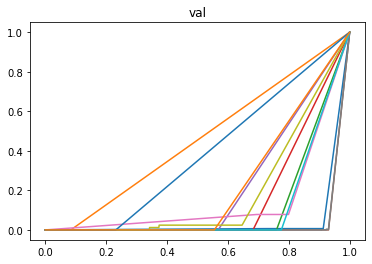

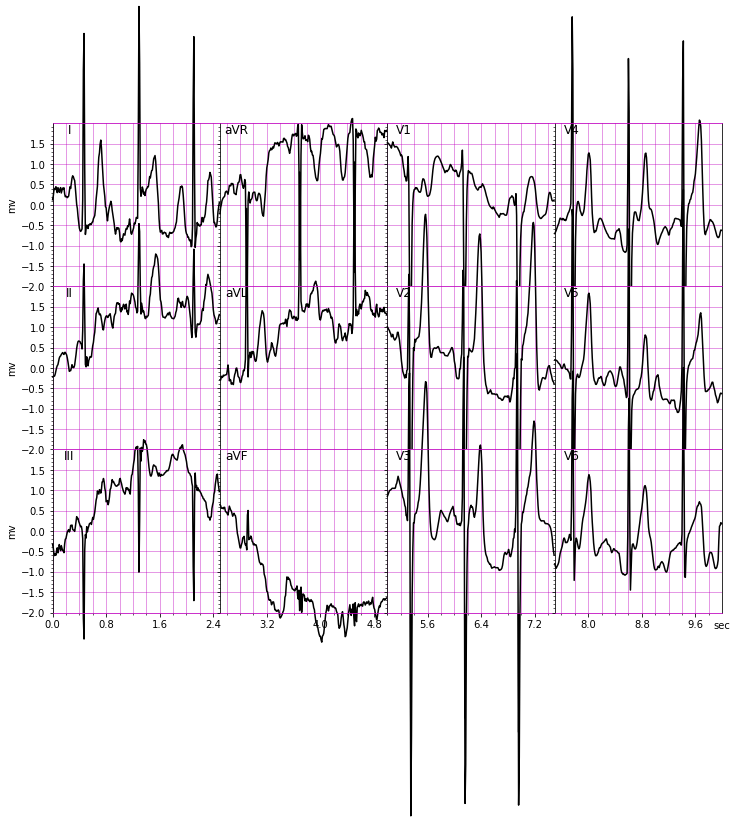

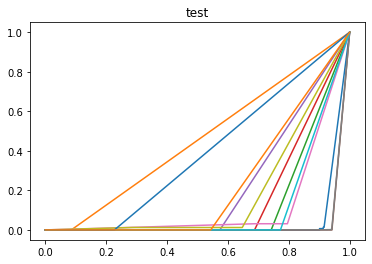

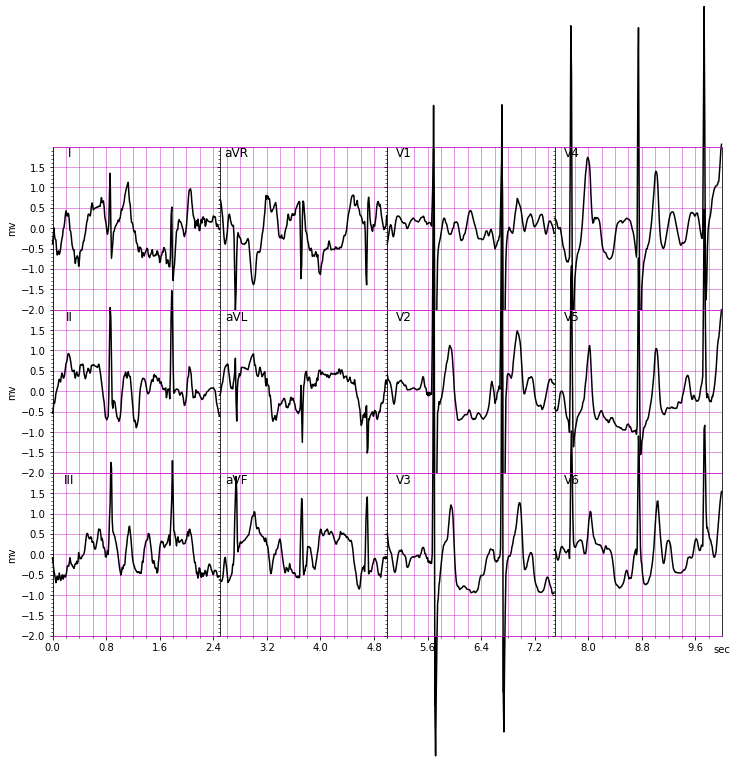

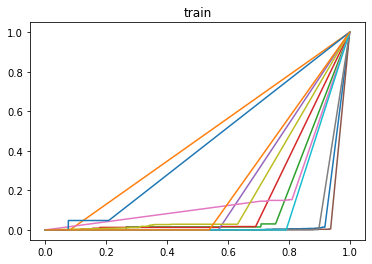

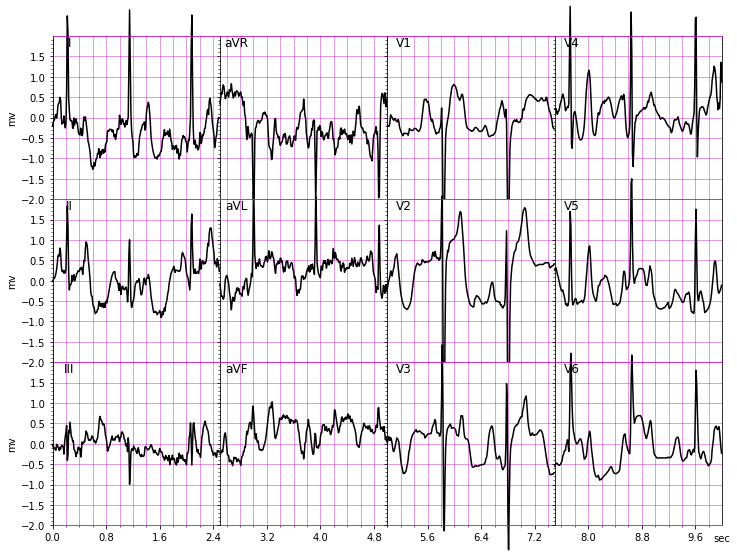

In [ ]:
for data_type in ("val", "test", "train"):
    print(f"SAP attacking {data_type} set")
    print("======================")
    examples = SAP.generate_examples(
            saved_file="drive/MyDrive/CSC2516_PTBXL/model_lstm_20210417_163400.pt",
            dataset_file=file,
            data_type = data_type,
            device = "cuda"
        )
    assert examples is not None
    # Performance post-attack
    dataset = util.PTBXLDataset(file=file, X=examples, data_type=data_type)
    dataset, y_pred = util.get_prediction(
        saved_file="drive/MyDrive/CSC2516_PTBXL/model_lstm_20210417_163400.pt", 
        dataset=dataset
    )
    sensitivity_specificity_curves = util.get_sensitivity_specificity_curves(
        truth=dataset.y, pred=y_pred
    )
    fig, ax = plt.subplots()
    ax.plot(1-sensitivity_specificity_curves[..., 1].T, sensitivity_specificity_curves[..., 0].T)
    ax.set_title(f"{data_type}")

    print(f"{data_type} AUC for each category")
    auc = np.trapz(x=1-sensitivity_specificity_curves[..., 1], y=sensitivity_specificity_curves[..., 0], axis=1)
    print(auc)
    print(f"{data_type} AUC mean")
    print(auc.mean())
    util.plot_ecg(dataset.X[0, ...])

## ResNet1D

In [ ]:
in_channels = 12
base_filters = 64
kernel_size = 16
stride = 2
groups = 32
n_block = 18
n_classes = 12

config = {
    "device": 'cuda' if torch.cuda.is_available() else 'cpu',
    "model_class": ResNet1D, 
    "model_kwargs": dict(
        in_channels=in_channels, 
        base_filters=base_filters, 
        kernel_size=kernel_size, 
        stride=stride, 
        groups=groups, 
        n_block=n_block, 
        n_classes=n_classes, # , downsample_gap=2, increasefilter_gap=4, use_bn=True, use_do=True, verbose=False
        verbose=False
    ),
    "X_type": torch.float32, 
    "y_type": torch.float32,
    "data_file": file,
    "data_train_key": "train",
    "data_val_key": "val",
    "data_test_key": "test",
    "train_batch_size": 512,
    "train_epoches": 10,
    "train_loss_class": nn.BCELoss,
    "train_optimizer_class": torch.optim.Adam,
    "train_optimizer_kwargs": dict(
        lr=1e-3,
        weight_decay=0
    ),
    "train_print_interval": 10, 
    "save_model_file": f"model_resnet1d_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.pt"
}
pprint.PrettyPrinter().pprint(config)
train_results = util.train(config)


NameError: ignored

No handles with labels found to put in legend.


model_resnet1d_20210417_145517.pt train AUC for each category
[0.9904049  0.95203476 0.92318783 0.97947415 0.96251387 0.78374433
 0.97325666 0.94231519 0.99540976 0.73622887 0.98430945 0.89663447]
model_resnet1d_20210417_145517.pt train AUC mean
0.926626186622638


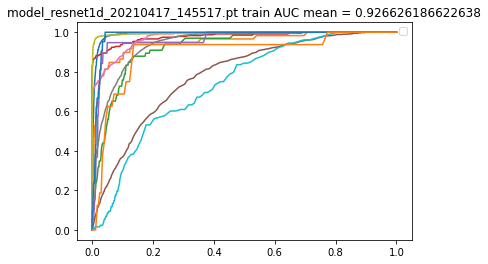

In [ ]:
get_performance("model_resnet1d_20210417_145517.pt", data_type="train")

No handles with labels found to put in legend.


model_resnet1d_20210417_145517.pt val AUC for each category
[0.98423347 0.98114041 0.95246311 0.90166747 0.96422919 0.7872386
 0.97561125 0.93598611 0.99586996 0.73712194 0.97451725 0.92180826]
model_resnet1d_20210417_145517.pt val AUC mean
0.9259905836540908


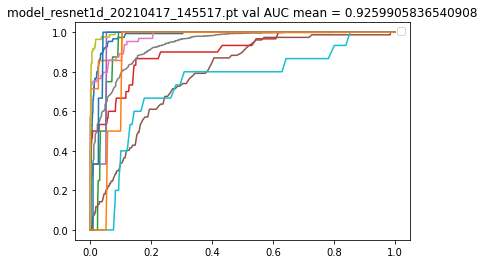

In [ ]:
get_performance("model_resnet1d_20210417_145517.pt", data_type="val")

Loading file = drive/MyDrive/CSC2516_PTBXL/data/ptbxl/export/rhythm.npz key = X_test
Loading file = drive/MyDrive/CSC2516_PTBXL/data/ptbxl/export/rhythm.npz key = y_test


No handles with labels found to put in legend.


model_resnet1d_20210417_145517.pt test AUC for each category
[0.97969496 0.95154035 0.88800716 0.90686829 0.99059971 0.77468238
 0.94968811 0.91731894 0.99326583 0.66985229 0.96984127 0.8710138 ]
model_resnet1d_20210417_145517.pt test AUC mean
0.9051977573535609


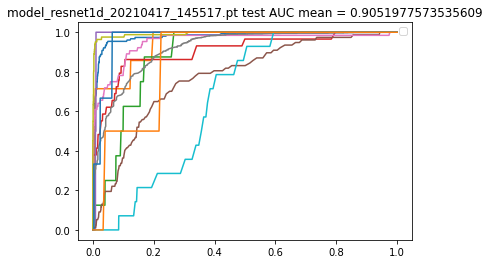

In [ ]:
get_performance("model_resnet1d_20210417_145517.pt", data_type="test")

### FGSM

In [ ]:
for data_type in ("val", "test", "train"):
    print(f"FGSM attacking {data_type} set")
    print("======================")
    examples = FGSM.generate_examples(
            saved_file="drive/MyDrive/CSC2516_PTBXL/model_resnet1d_20210417_145517.pt",
            dataset_file=file,
            data_type = data_type,
            device = "cuda",
            epsilon = 0.05
        )
    # Performance post-attack
    dataset = util.PTBXLDataset(file=file, X=examples, data_type=data_type)
    dataset, y_pred = util.get_prediction(
        saved_file="drive/MyDrive/CSC2516_PTBXL/model_resnet1d_20210417_145517.pt", 
        dataset=dataset
    )
    sensitivity_specificity_curves = util.get_sensitivity_specificity_curves(
        truth=dataset.y, pred=y_pred
    )
    fig, ax = plt.subplots()
    ax.plot(1-sensitivity_specificity_curves[..., 1].T, sensitivity_specificity_curves[..., 0].T)
    ax.set_title(f"{data_type}")

    print(f"{data_type} AUC for each category")
    auc = np.trapz(x=1-sensitivity_specificity_curves[..., 1], y=sensitivity_specificity_curves[..., 0], axis=1)
    print(auc)
    print(f"{data_type} AUC mean")
    print(auc.mean())
    util.plot_ecg(dataset.X[0, ...])

FGSM attacking train set
train AUC for each category
[0.98984653 0.97426279 0.91588353 0.98151456 0.92694567 0.79699383
 0.97397182 0.9438928  0.99843783 0.73941884 0.98307631 0.95462219]
train AUC mean
0.9315722249696906


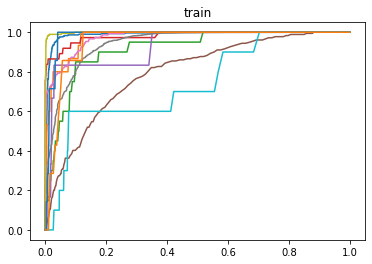

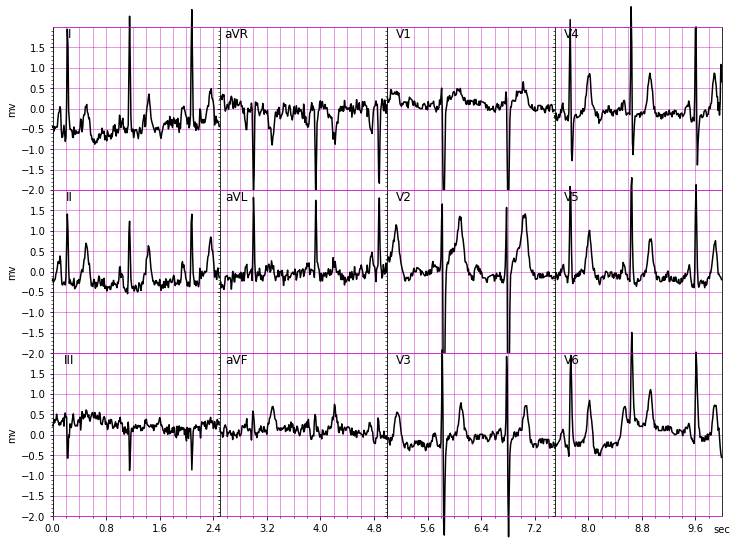

In [ ]:
for data_type in ("train", ):
    print(f"FGSM attacking {data_type} set")
    print("======================")
    examples = FGSM.generate_examples(
            saved_file="drive/MyDrive/CSC2516_PTBXL/model_resnet1d_20210417_145517.pt",
            dataset_file=file,
            data_type = data_type,
            device = "cuda",
            epsilon = 0.05,
            n = 5000
        )
    # Performance post-attack
    dataset = util.PTBXLDataset(file=file, data_type=data_type)
    dataset = util.PTBXLDataset(file=file, X=examples, y=dataset.y[0:len(examples), ...])
    dataset, y_pred = util.get_prediction(
        saved_file="drive/MyDrive/CSC2516_PTBXL/model_resnet1d_20210417_145517.pt", 
        dataset=dataset
    )
    sensitivity_specificity_curves = util.get_sensitivity_specificity_curves(
        truth=dataset.y, pred=y_pred
    )
    fig, ax = plt.subplots()
    ax.plot(1-sensitivity_specificity_curves[..., 1].T, sensitivity_specificity_curves[..., 0].T)
    ax.set_title(f"{data_type}")

    print(f"{data_type} AUC for each category")
    auc = np.trapz(x=1-sensitivity_specificity_curves[..., 1], y=sensitivity_specificity_curves[..., 0], axis=1)
    print(auc)
    print(f"{data_type} AUC mean")
    print(auc.mean())
    util.plot_ecg(dataset.X[0, ...])

### SAP

SAP attacking val set
Loading file = drive/MyDrive/CSC2516_PTBXL/data/ptbxl/export/rhythm.npz key = X_val
Loading file = drive/MyDrive/CSC2516_PTBXL/data/ptbxl/export/rhythm.npz key = y_val
*************
sizes: (5, 7, 11, 15, 19)
sigmas: (1.0, 3.0, 5.0, 7.0, 10.0)
eps = 0.5
step_alpha = 0.02
num_steps = 20
Generating examples for batch 0
Generating examples for batch 1
Generating examples for batch 2
Generating examples for batch 3
Generating examples for batch 4
val AUC for each category
[0.41957769 0.93319288 0.76195859 0.45302229 0.90163026 0.21772101
 0.92000688 0.55050552 0.95603837 0.14447628 0.96731561 0.4915757 ]
val AUC mean
0.6430850888418932
SAP attacking test set
Loading file = drive/MyDrive/CSC2516_PTBXL/data/ptbxl/export/rhythm.npz key = X_test
Loading file = drive/MyDrive/CSC2516_PTBXL/data/ptbxl/export/rhythm.npz key = y_test
*************
sizes: (5, 7, 11, 15, 19)
sigmas: (1.0, 3.0, 5.0, 7.0, 10.0)
eps = 0.5
step_alpha = 0.02
num_steps = 20
Generating examples for batc

KeyboardInterrupt: ignored

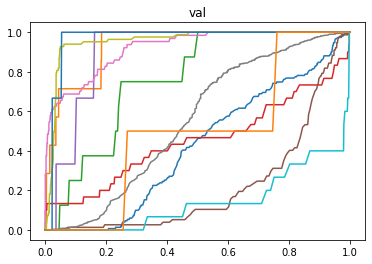

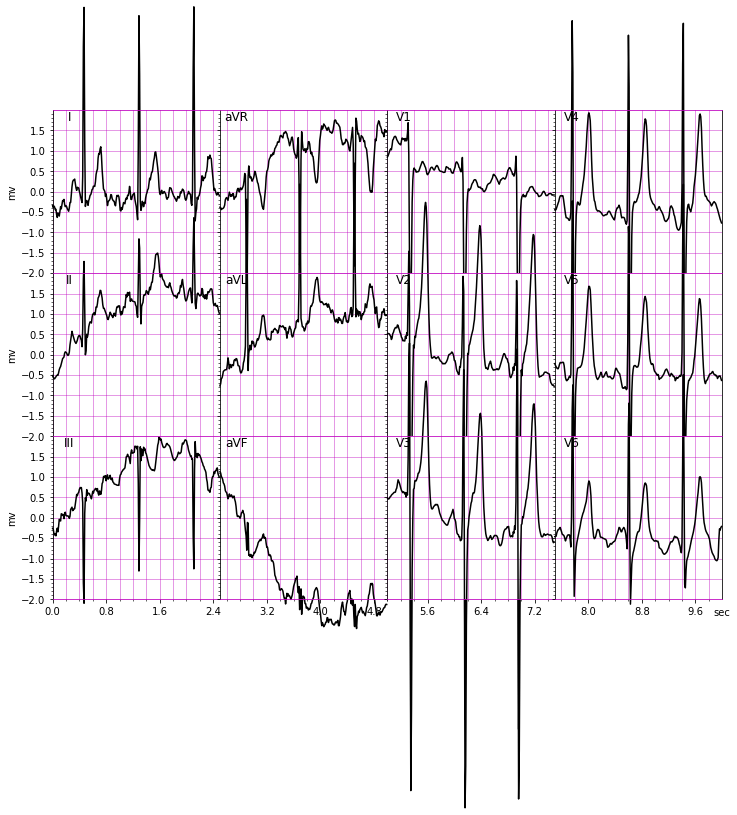

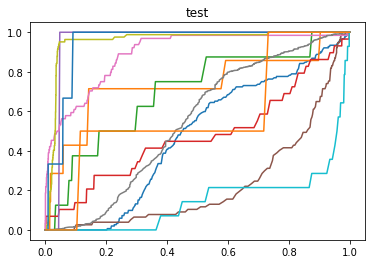

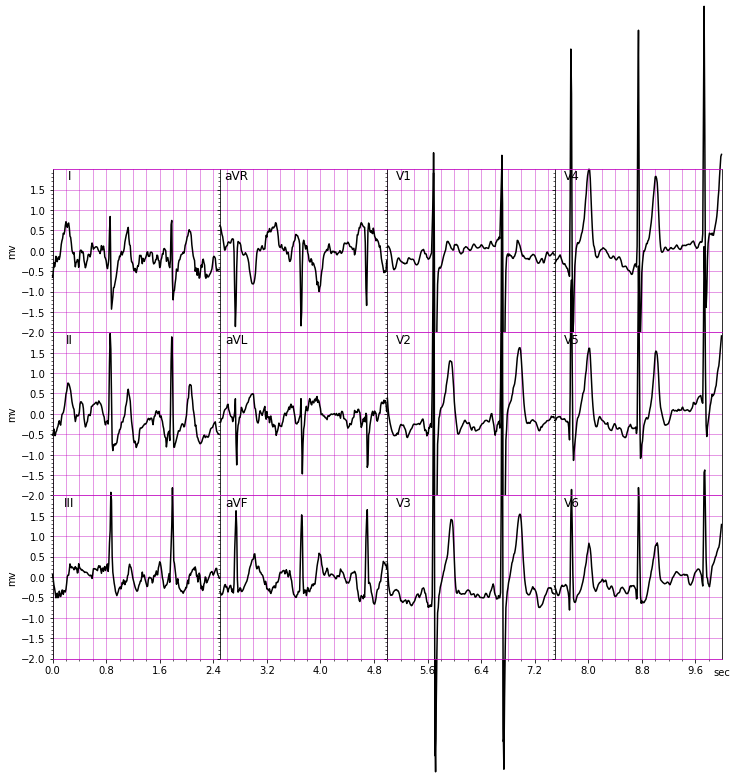

In [ ]:
for data_type in ("val", "test", "train"):
    print(f"SAP attacking {data_type} set")
    print("======================")
    examples = SAP.generate_examples(
            saved_file="drive/MyDrive/CSC2516_PTBXL/model_resnet1d_20210417_145517.pt",
            dataset_file=file,
            data_type = data_type,
            device = "cuda"
        )
    assert examples is not None
    # Performance post-attack
    dataset = util.PTBXLDataset(file=file, X=examples, data_type=data_type)
    dataset, y_pred = util.get_prediction(
        saved_file="drive/MyDrive/CSC2516_PTBXL/model_resnet1d_20210417_145517.pt", 
        dataset=dataset
    )
    sensitivity_specificity_curves = util.get_sensitivity_specificity_curves(
        truth=dataset.y, pred=y_pred
    )
    fig, ax = plt.subplots()
    ax.plot(1-sensitivity_specificity_curves[..., 1].T, sensitivity_specificity_curves[..., 0].T)
    ax.set_title(f"{data_type}")

    print(f"{data_type} AUC for each category")
    auc = np.trapz(x=1-sensitivity_specificity_curves[..., 1], y=sensitivity_specificity_curves[..., 0], axis=1)
    print(auc)
    print(f"{data_type} AUC mean")
    print(auc.mean())
    util.plot_ecg(dataset.X[0, ...])

SAP attacking train set
Loading file = drive/MyDrive/CSC2516_PTBXL/data/ptbxl/export/rhythm.npz key = X_train
Loading file = drive/MyDrive/CSC2516_PTBXL/data/ptbxl/export/rhythm.npz key = y_train
*************
sizes: (5, 7, 11, 15, 19)
sigmas: (1.0, 3.0, 5.0, 7.0, 10.0)
eps = 0.5
step_alpha = 0.02
num_steps = 20
Generating examples for batch 0
Generating examples for batch 1
Generating examples for batch 2
Generating examples for batch 3
Generating examples for batch 4
Generating examples for batch 5
Generating examples for batch 6
Generating examples for batch 7
Generating examples for batch 8
Generating examples for batch 9
train AUC for each category
[0.58259129 0.84225922 0.85856557 0.80749026 0.80255182 0.32516152
 0.9389216  0.67409119 0.9717321  0.25236214 0.9603751  0.87058199]
train AUC mean
0.7405569834756881


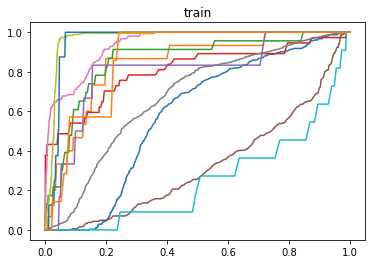

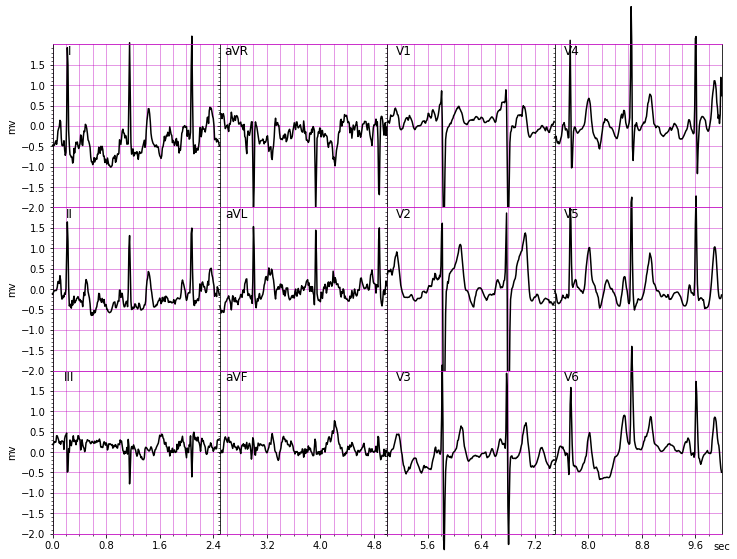

In [ ]:
for data_type in ("train",):
    print(f"SAP attacking {data_type} set")
    print("======================")
    examples = SAP.generate_examples(
            saved_file="drive/MyDrive/CSC2516_PTBXL/model_resnet1d_20210417_145517.pt",
            dataset_file=file,
            data_type = data_type,
            device = "cuda",
            n = 5000
        )
    assert examples is not None
    # Performance post-attack
    dataset = util.PTBXLDataset(file=file, data_type=data_type)
    dataset = util.PTBXLDataset(file=file, X=examples, y=dataset.y[0:len(examples), ...])
    dataset, y_pred = util.get_prediction(
        saved_file="drive/MyDrive/CSC2516_PTBXL/model_resnet1d_20210417_145517.pt", 
        dataset=dataset
    )
    sensitivity_specificity_curves = util.get_sensitivity_specificity_curves(
        truth=dataset.y, pred=y_pred
    )
    fig, ax = plt.subplots()
    ax.plot(1-sensitivity_specificity_curves[..., 1].T, sensitivity_specificity_curves[..., 0].T)
    ax.set_title(f"{data_type}")

    print(f"{data_type} AUC for each category")
    auc = np.trapz(x=1-sensitivity_specificity_curves[..., 1], y=sensitivity_specificity_curves[..., 0], axis=1)
    print(auc)
    print(f"{data_type} AUC mean")
    print(auc.mean())
    util.plot_ecg(dataset.X[0, ...])

## Inception

In [ ]:

config = {
    "device": 'cuda' if torch.cuda.is_available() else 'cpu',
    "model_class": InceptionModel, 
    "model_kwargs": dict(
        num_blocks=6, in_channels=12, out_channels=128,
        bottleneck_channels=32, kernel_sizes=40, use_residuals=True,
        num_pred_classes=12
    ),
    "X_type": torch.float32, 
    "y_type": torch.float32,
    "data_file": file,
    "data_train_key": "train",
    "data_val_key": "val",
    "data_test_key": "test",
    "train_batch_size": 32,
    "train_epoches": 10,
    "train_loss_class": nn.BCELoss,
    "train_optimizer_class": torch.optim.Adam,
    "train_optimizer_kwargs": dict(
        lr=5e-5,
        weight_decay=0
    ),
    "train_print_interval": 10, 
    "save_model_file": f"model_inception_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.pt"
}
pprint.PrettyPrinter().pprint(config)
train_results = util.train(config)


{'X_type': torch.float32,
 'data_file': PosixPath('drive/MyDrive/CSC2516_PTBXL/data/ptbxl/export/rhythm.npz'),
 'data_test_key': 'test',
 'data_train_key': 'train',
 'data_val_key': 'val',
 'device': 'cuda',
 'model_class': <class '__main__.InceptionModel'>,
 'model_kwargs': {'bottleneck_channels': 32,
                  'in_channels': 12,
                  'kernel_sizes': 40,
                  'num_blocks': 6,
                  'num_pred_classes': 12,
                  'out_channels': 128,
                  'use_residuals': True},
 'save_model_file': 'model_inception_20210418_011356.pt',
 'train_batch_size': 32,
 'train_epoches': 10,
 'train_loss_class': <class 'torch.nn.modules.loss.BCELoss'>,
 'train_optimizer_class': <class 'torch.optim.adam.Adam'>,
 'train_optimizer_kwargs': {'lr': 5e-05, 'weight_decay': 0},
 'train_print_interval': 10,
 'y_type': torch.float32}
Starting training 2021-04-18 01:13:56.269735
[1,     1] loss: 0.756, AUC: [0.98387097        nan 0.93548387 0.17741935   

No handles with labels found to put in legend.


model_inception_20210418_011356.pt train AUC for each category
[0.99432797 0.98919069 0.91246724 0.98368277 0.98575024 0.68224858
 0.98260398 0.93097894 0.99831169 0.90222301 0.99382449 0.90894665]
model_inception_20210418_011356.pt train AUC mean
0.9387130198072584


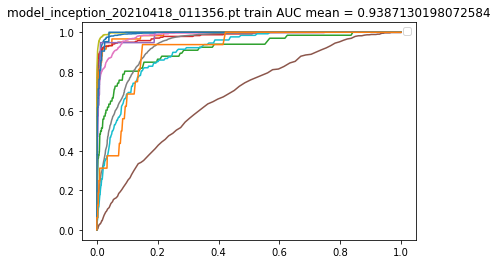

In [ ]:
get_performance("model_inception_20210418_011356.pt", data_type="train")

No handles with labels found to put in legend.


model_inception_20210418_011356.pt val AUC for each category
[0.98364834 0.99269403 0.85102332 0.97546898 0.99074074 0.63842801
 0.97422066 0.91457901 0.99368154 0.91703279 0.98678379 0.88407689]
model_inception_20210418_011356.pt val AUC mean
0.9251981743855796


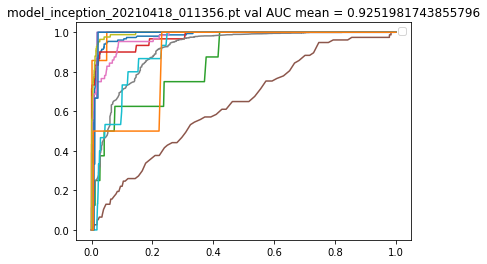

In [ ]:
get_performance("model_inception_20210418_011356.pt", data_type="val")

Loading file = drive/MyDrive/CSC2516_PTBXL/data/ptbxl/export/rhythm.npz key = X_test
Loading file = drive/MyDrive/CSC2516_PTBXL/data/ptbxl/export/rhythm.npz key = y_test


No handles with labels found to put in legend.


model_inception_20210418_011356.pt test AUC for each category
[0.97631275 0.93082061 0.84752387 0.92512387 0.99904807 0.68180857
 0.95738567 0.89842179 0.98998322 0.8799152  0.99222222 0.66492147]
model_inception_20210418_011356.pt test AUC mean
0.895290609051843


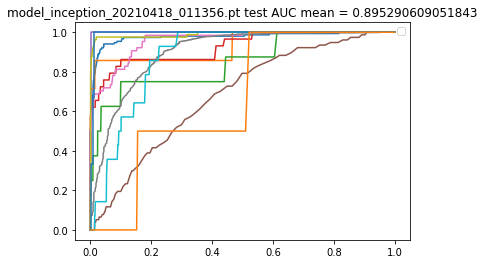

In [ ]:
get_performance("model_inception_20210418_011356.pt", data_type="test")

#### FGSM

FGSM attacking val set
Generating:0/2109
Generating:1000/2109
Generating:2000/2109
val AUC for each category
[0.94809205 0.98892211 0.78718467 0.96320346 0.98868313 0.56937698
 0.9612584  0.8217059  0.99141581 0.77112385 0.98654638 0.83780256]
val AUC mean
0.8846096097380068
FGSM attacking test set
Generating:0/2103
Generating:1000/2103
Generating:2000/2103
test AUC for each category
[0.93558634 0.90924891 0.80384845 0.90296113 0.99904807 0.6140402
 0.94121276 0.80376148 0.98670062 0.71727758 0.99238095 0.50773441]
test AUC mean
0.8428167416978817
FGSM attacking train set
Generating:0/16854
Generating:1000/16854
Generating:2000/16854
Generating:3000/16854
Generating:4000/16854
Generating:5000/16854
Generating:6000/16854
Generating:7000/16854
Generating:8000/16854
Generating:9000/16854
Generating:10000/16854
Generating:11000/16854
Generating:12000/16854
Generating:13000/16854
Generating:14000/16854
Generating:15000/16854
Generating:16000/16854
train AUC for each category
[0.97125824 0.9

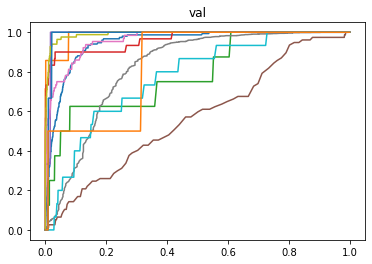

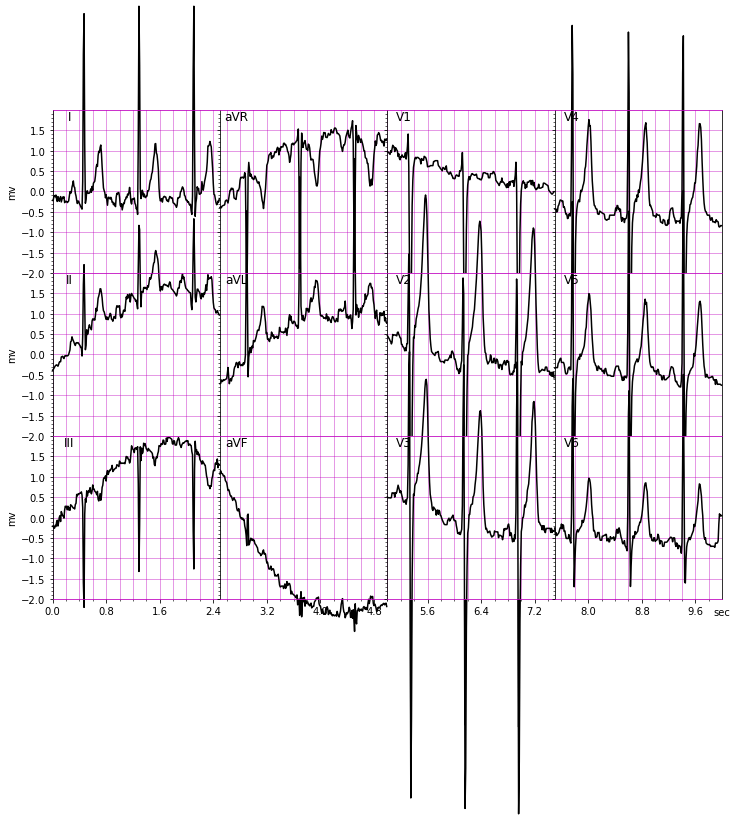

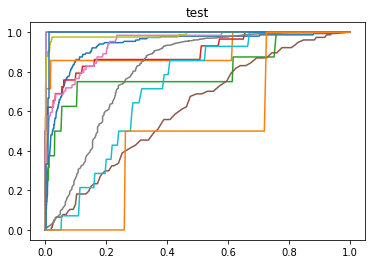

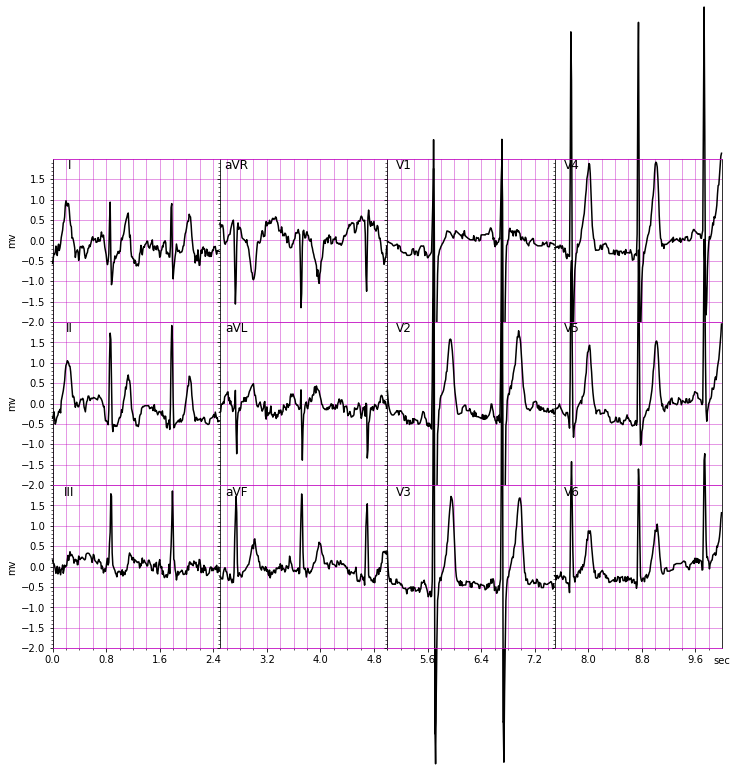

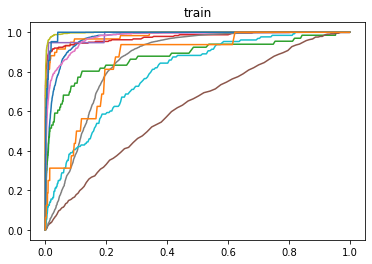

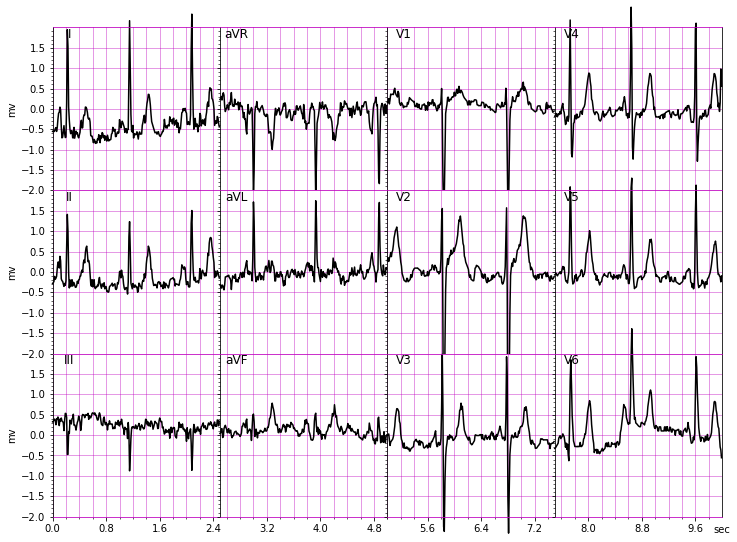

In [ ]:
for data_type in ("val", "test", "train", ):
    print(f"FGSM attacking {data_type} set")
    print("======================")
    examples = FGSM.generate_examples(
            saved_file="drive/MyDrive/CSC2516_PTBXL/model_inception_20210418_011356.pt",
            dataset_file=file,
            data_type = data_type,
            device = "cuda",
            epsilon = 0.05
        )
    # Performance post-attack
    dataset = util.PTBXLDataset(file=file, data_type=data_type)
    dataset = util.PTBXLDataset(file=file, X=examples, y=dataset.y[0:len(examples), ...])
    dataset, y_pred = util.get_prediction(
        saved_file="drive/MyDrive/CSC2516_PTBXL/model_inception_20210418_011356.pt", 
        dataset=dataset
    )
    sensitivity_specificity_curves = util.get_sensitivity_specificity_curves(
        truth=dataset.y, pred=y_pred
    )
    fig, ax = plt.subplots()
    ax.plot(1-sensitivity_specificity_curves[..., 1].T, sensitivity_specificity_curves[..., 0].T)
    ax.set_title(f"{data_type}")

    print(f"{data_type} AUC for each category")
    auc = np.trapz(x=1-sensitivity_specificity_curves[..., 1], y=sensitivity_specificity_curves[..., 0], axis=1)
    print(auc)
    print(f"{data_type} AUC mean")
    print(auc.mean())
    util.plot_ecg(dataset.X[0, ...])

#### SAP

SAP attacking val set
Loading file = drive/MyDrive/CSC2516_PTBXL/data/ptbxl/export/rhythm.npz key = X_val
Loading file = drive/MyDrive/CSC2516_PTBXL/data/ptbxl/export/rhythm.npz key = y_val
*************
sizes: (5, 7, 11, 15, 19)
sigmas: (1.0, 3.0, 5.0, 7.0, 10.0)
eps = 0.5
step_alpha = 0.02
num_steps = 20
Generating examples for batch 0
Generating examples for batch 1
Generating examples for batch 2
Generating examples for batch 3
Generating examples for batch 4
val AUC for each category
[0.10458537 0.71217888 0.21037601 0.62925285 0.38358658 0.25296873
 0.05605517 0.17220396 0.3604824  0.19051258 0.39553656 0.1206692 ]
val AUC mean
0.29903402262483675
SAP attacking test set
Loading file = drive/MyDrive/CSC2516_PTBXL/data/ptbxl/export/rhythm.npz key = X_test
Loading file = drive/MyDrive/CSC2516_PTBXL/data/ptbxl/export/rhythm.npz key = y_test
*************
sizes: (5, 7, 11, 15, 19)
sigmas: (1.0, 3.0, 5.0, 7.0, 10.0)
eps = 0.5
step_alpha = 0.02
num_steps = 20
Generating examples for bat

KeyboardInterrupt: ignored

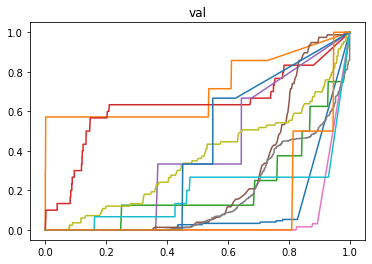

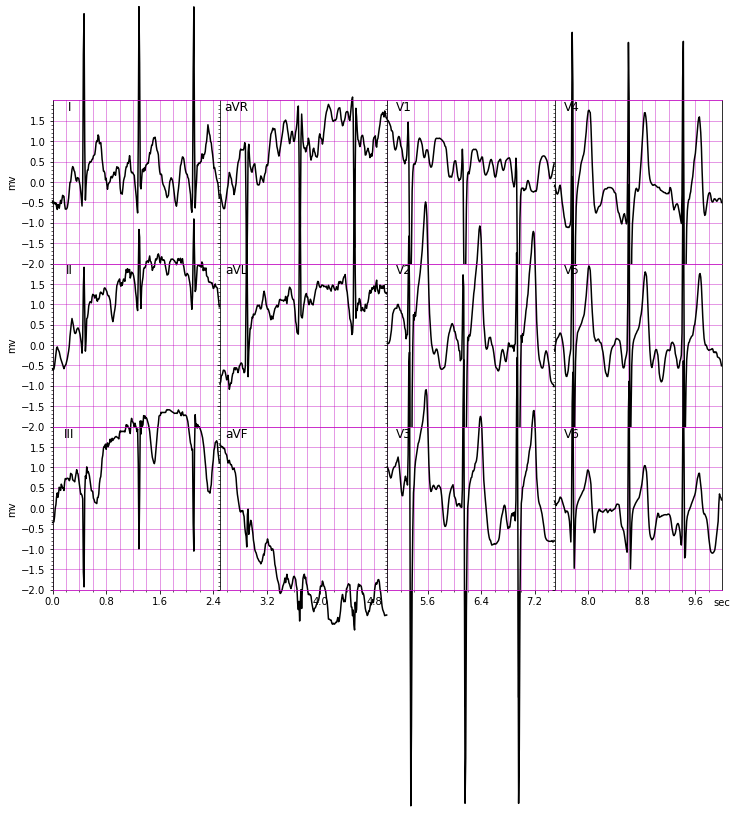

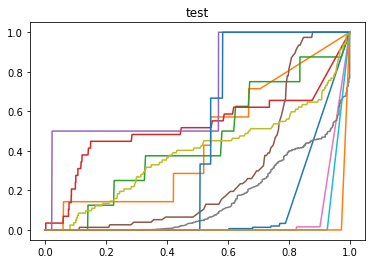

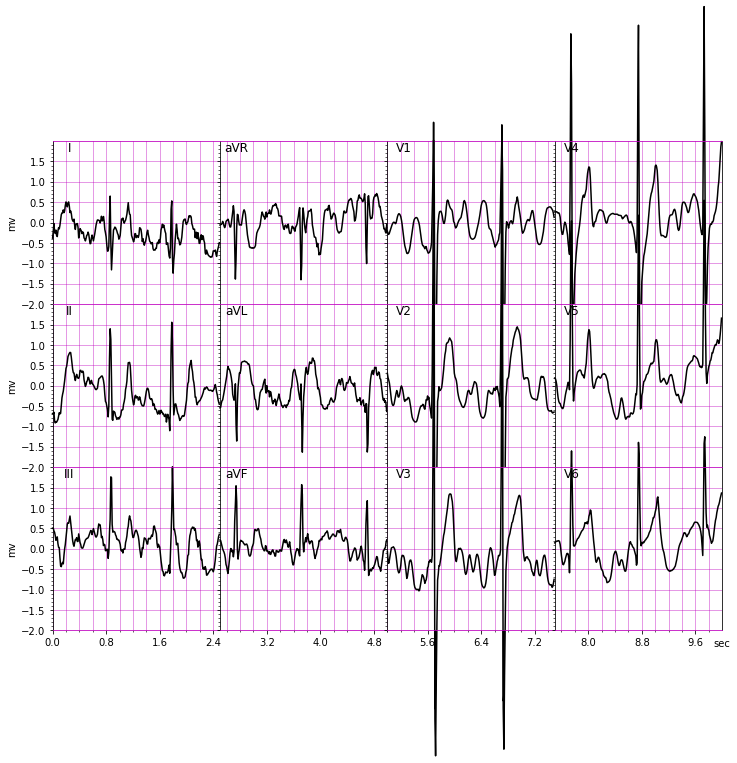

In [ ]:
for data_type in ("val", "test", "train"):
    print(f"SAP attacking {data_type} set")
    print("======================")
    examples = SAP.generate_examples(
            saved_file="drive/MyDrive/CSC2516_PTBXL/model_inception_20210418_011356.pt",
            dataset_file=file,
            data_type = data_type,
            device = "cuda"
        )
    assert examples is not None
    # Performance post-attack
    dataset = util.PTBXLDataset(file=file, X=examples, data_type=data_type)
    dataset, y_pred = util.get_prediction(
        saved_file="drive/MyDrive/CSC2516_PTBXL/model_inception_20210418_011356.pt", 
        dataset=dataset
    )
    sensitivity_specificity_curves = util.get_sensitivity_specificity_curves(
        truth=dataset.y, pred=y_pred
    )
    fig, ax = plt.subplots()
    ax.plot(1-sensitivity_specificity_curves[..., 1].T, sensitivity_specificity_curves[..., 0].T)
    ax.set_title(f"{data_type}")

    print(f"{data_type} AUC for each category")
    auc = np.trapz(x=1-sensitivity_specificity_curves[..., 1], y=sensitivity_specificity_curves[..., 0], axis=1)
    print(auc)
    print(f"{data_type} AUC mean")
    print(auc.mean())
    util.plot_ecg(dataset.X[0, ...])

SAP attacking train set
*************
sizes: (5, 7, 11, 15, 19)
sigmas: (1.0, 3.0, 5.0, 7.0, 10.0)
eps = 0.5
step_alpha = 0.02
num_steps = 20
Generating examples for batch 0
Generating examples for batch 1
Generating examples for batch 2
Generating examples for batch 3
Generating examples for batch 4
Generating examples for batch 5
Generating examples for batch 6
Generating examples for batch 7
Generating examples for batch 8
Generating examples for batch 9
train AUC for each category
[0.19065148 0.53086516 0.546515   0.75544076 0.49586104 0.26567785
 0.05728968 0.24241498 0.42420752 0.27922205 0.51810691 0.23673549]
train AUC mean
0.37858232706872635


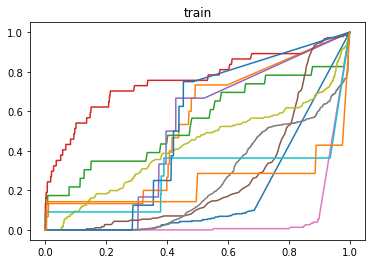

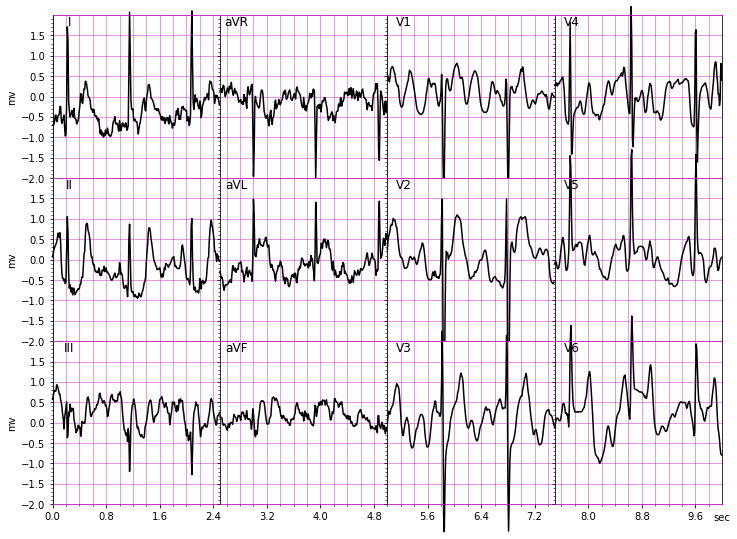

In [ ]:
for data_type in ("train",):
    print(f"SAP attacking {data_type} set")
    print("======================")
    examples = SAP.generate_examples(
            saved_file="drive/MyDrive/CSC2516_PTBXL/model_inception_20210418_011356.pt",
            dataset_file=file,
            data_type = data_type,
            device = "cuda",
            n = 5000
        )
    assert examples is not None
    # Performance post-attack
    dataset = util.PTBXLDataset(file=file, data_type=data_type)
    dataset = util.PTBXLDataset(file=file, X=examples, y=dataset.y[0:len(examples), ...])
    dataset, y_pred = util.get_prediction(
        saved_file="drive/MyDrive/CSC2516_PTBXL/model_inception_20210418_011356.pt", 
        dataset=dataset
    )
    sensitivity_specificity_curves = util.get_sensitivity_specificity_curves(
        truth=dataset.y, pred=y_pred
    )
    fig, ax = plt.subplots()
    ax.plot(1-sensitivity_specificity_curves[..., 1].T, sensitivity_specificity_curves[..., 0].T)
    ax.set_title(f"{data_type}")

    print(f"{data_type} AUC for each category")
    auc = np.trapz(x=1-sensitivity_specificity_curves[..., 1], y=sensitivity_specificity_curves[..., 0], axis=1)
    print(auc)
    print(f"{data_type} AUC mean")
    print(auc.mean())
    util.plot_ecg(dataset.X[0, ...])

## XResNet

In [ ]:
# def xresnet101(**kwargs): return XResNet.create(4, [3, 4, 23, 3], **kwargs)

config = {
    "device": 'cuda' if torch.cuda.is_available() else 'cpu',
    "model_class": XResNet.create, 
    "model_kwargs": dict(
        expansion=4,
        layers=[3, 4, 23, 3]
    ),
    "X_type": torch.float32, 
    "y_type": torch.float32,
    "data_file": file,
    "data_train_key": "train",
    "data_val_key": "val",
    "data_test_key": "test",
    "train_batch_size": 64,
    "train_epoches": 10,
    "train_loss_class": nn.BCELoss,
    "train_optimizer_class": torch.optim.Adam,
    "train_optimizer_kwargs": dict(
        lr=1e-3,
        weight_decay=0
    ),
    "train_print_interval": 10, 
    "save_model_file": f"model_xresnet_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.pt"
}
pprint.PrettyPrinter().pprint(config)
train_results = util.train(config)


{'X_type': torch.float32,
 'data_file': PosixPath('drive/MyDrive/CSC2516_PTBXL/data/ptbxl/export/rhythm.npz'),
 'data_test_key': 'test',
 'data_train_key': 'train',
 'data_val_key': 'val',
 'device': 'cuda',
 'model_class': <bound method XResNet.create of <class '__main__.XResNet'>>,
 'model_kwargs': {'expansion': 4, 'layers': [3, 4, 23, 3]},
 'save_model_file': 'model_xresnet_20210418_014941.pt',
 'train_batch_size': 64,
 'train_epoches': 10,
 'train_loss_class': <class 'torch.nn.modules.loss.BCELoss'>,
 'train_optimizer_class': <class 'torch.optim.adam.Adam'>,
 'train_optimizer_kwargs': {'lr': 0.001, 'weight_decay': 0},
 'train_print_interval': 10,
 'y_type': torch.float32}
Starting training 2021-04-18 01:49:42.161893
[1,     1] loss: 0.790, AUC: [0.72556391 0.96825397 0.81854839        nan        nan 0.30054645
 0.64791667 0.48369565 0.48087432        nan        nan        nan]
[1,    11] loss: 0.242, AUC: [0.67514698        nan        nan        nan        nan        nan
        na

No handles with labels found to put in legend.


drive/MyDrive/CSC2516_PTBXL/model_xresnet_20210418_014941.pt train AUC for each category
[0.99926712 0.9973499  0.99544678 0.99933625 0.99874322 0.8417622
 0.9888532  0.95976459 0.99926123 0.99292596 0.99838752 0.99593924]
drive/MyDrive/CSC2516_PTBXL/model_xresnet_20210418_014941.pt train AUC mean
0.9805864350491871


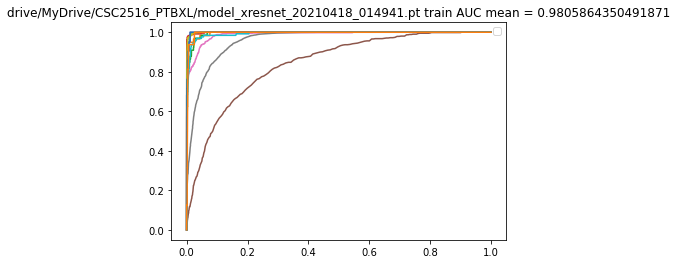

In [ ]:
get_performance('drive/MyDrive/CSC2516_PTBXL/model_xresnet_20210418_014941.pt', data_type="train")

No handles with labels found to put in legend.


drive/MyDrive/CSC2516_PTBXL/model_xresnet_20210418_014941.pt val AUC for each category
[0.99406071 0.98834443 0.96924084 0.96495911 0.99873378 0.66466727
 0.97783848 0.91853978 0.99688091 0.95563515 0.99525166 0.99644044]
drive/MyDrive/CSC2516_PTBXL/model_xresnet_20210418_014941.pt val AUC mean
0.9517160458852313


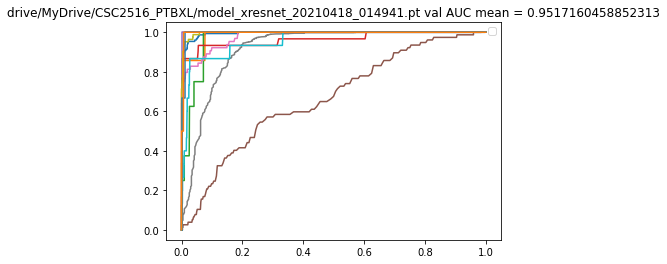

In [ ]:
get_performance('drive/MyDrive/CSC2516_PTBXL/model_xresnet_20210418_014941.pt', data_type="val")

No handles with labels found to put in legend.


drive/MyDrive/CSC2516_PTBXL/model_xresnet_20210418_014941.pt test AUC for each category
[0.98359984 0.8892789  0.9225537  0.96090347 0.99928605 0.71963821
 0.96002559 0.91300007 0.99027287 0.97079943 0.99579365 0.95799619]
drive/MyDrive/CSC2516_PTBXL/model_xresnet_20210418_014941.pt test AUC mean
0.9385956642480493


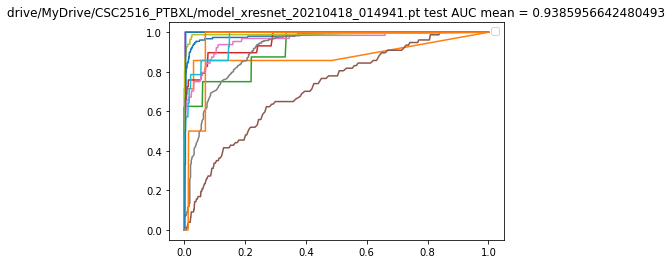

In [ ]:
get_performance('drive/MyDrive/CSC2516_PTBXL/model_xresnet_20210418_014941.pt', data_type="test")

### FGSM

In [ ]:
for data_type in ("train", "val", "test",  ):
    print(f"FGSM attacking {data_type} set")
    print("======================")
    examples = FGSM.generate_examples(
            saved_file="drive/MyDrive/CSC2516_PTBXL/model_xresnet_20210418_014941.pt",
            dataset_file=file,
            data_type = data_type,
            device = "cuda",
            epsilon = 0.05,
            n = 5000,
        )
    # Performance post-attack
    dataset = util.PTBXLDataset(file=file, data_type=data_type)
    dataset = util.PTBXLDataset(file=file, X=examples, y=dataset.y[0:len(examples), ...])
    dataset, y_pred = util.get_prediction(
        saved_file="drive/MyDrive/CSC2516_PTBXL/model_xresnet_20210418_014941.pt", 
        dataset=dataset
    )
    sensitivity_specificity_curves = util.get_sensitivity_specificity_curves(
        truth=dataset.y, pred=y_pred
    )
    fig, ax = plt.subplots()
    ax.plot(1-sensitivity_specificity_curves[..., 1].T, sensitivity_specificity_curves[..., 0].T)
    ax.set_title(f"{data_type}")

    print(f"{data_type} AUC for each category")
    auc = np.trapz(x=1-sensitivity_specificity_curves[..., 1], y=sensitivity_specificity_curves[..., 0], axis=1)
    print(auc)
    print(f"{data_type} AUC mean")
    print(auc.mean())
    util.plot_ecg(dataset.X[0, ...])

FGSM attacking train set
Loading file = drive/MyDrive/CSC2516_PTBXL/data/ptbxl/export/rhythm.npz key = X_train


KeyboardInterrupt: ignored

### SAP

SAP attacking val set
Loading file = drive/MyDrive/CSC2516_PTBXL/data/ptbxl/export/rhythm.npz key = X_val
Loading file = drive/MyDrive/CSC2516_PTBXL/data/ptbxl/export/rhythm.npz key = y_val
*************
sizes: (5, 7, 11, 15, 19)
sigmas: (1.0, 3.0, 5.0, 7.0, 10.0)
eps = 0.5
step_alpha = 0.02
num_steps = 20
Generating examples for batch 0
Generating examples for batch 1
Generating examples for batch 2
Generating examples for batch 3
Generating examples for batch 4
Generating examples for batch 5
Generating examples for batch 6
Generating examples for batch 7
Generating examples for batch 8
Generating examples for batch 9
Generating examples for batch 10
Generating examples for batch 11
Generating examples for batch 12
Generating examples for batch 13
Generating examples for batch 14
Generating examples for batch 15
Generating examples for batch 16
Generating examples for batch 17
Generating examples for batch 18
Generating examples for batch 19
Generating examples for batch 20
Generatin

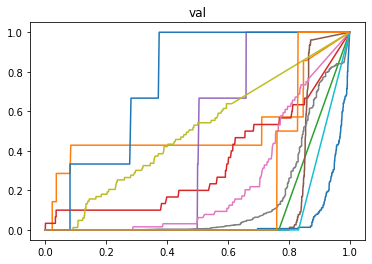

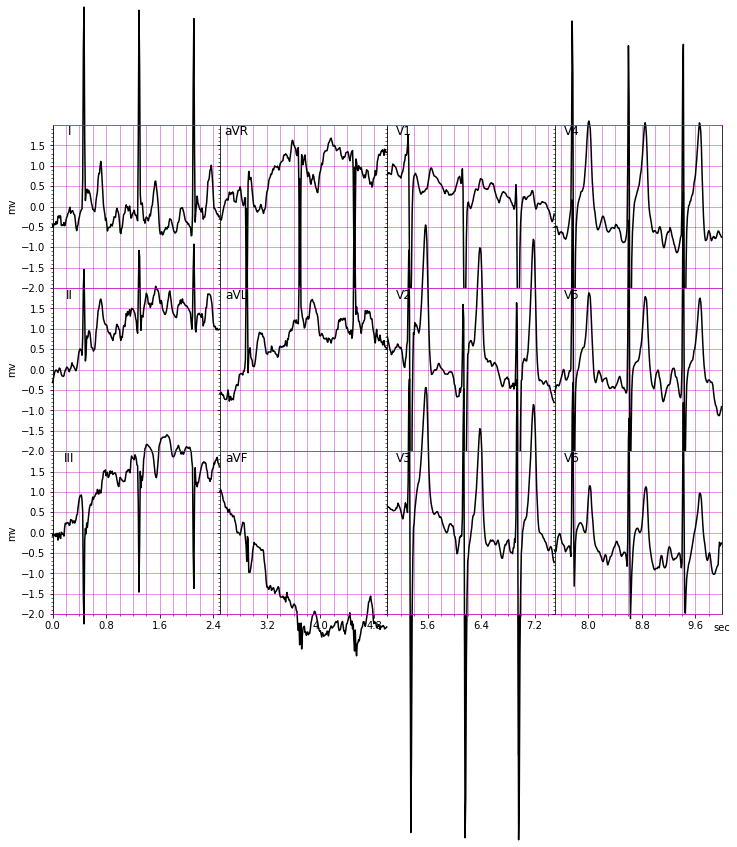

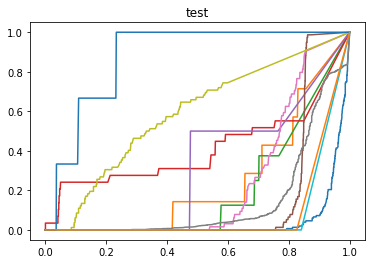

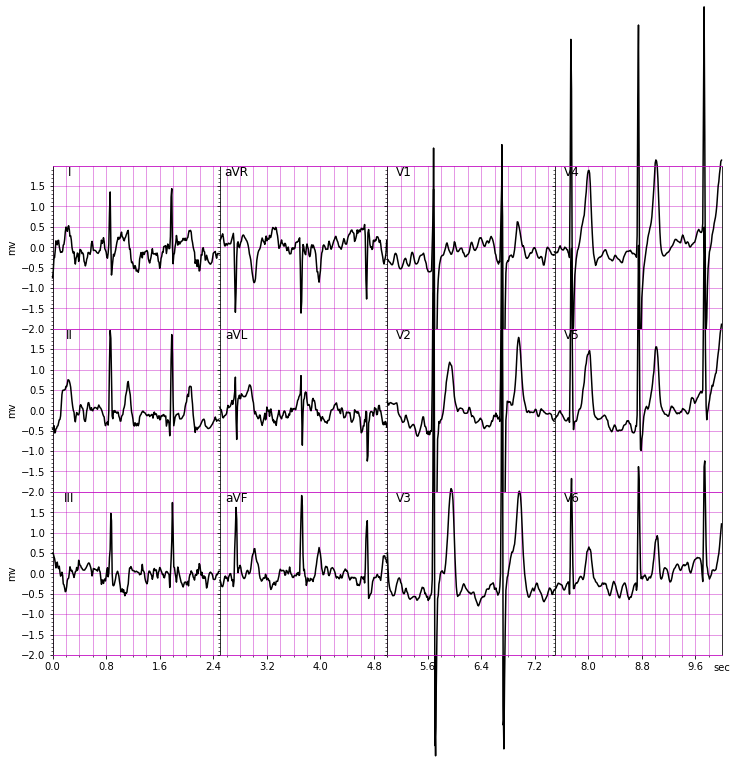

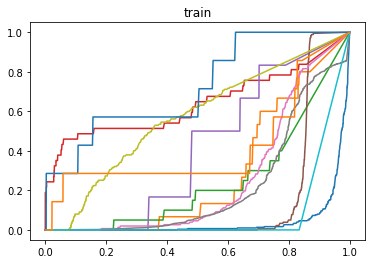

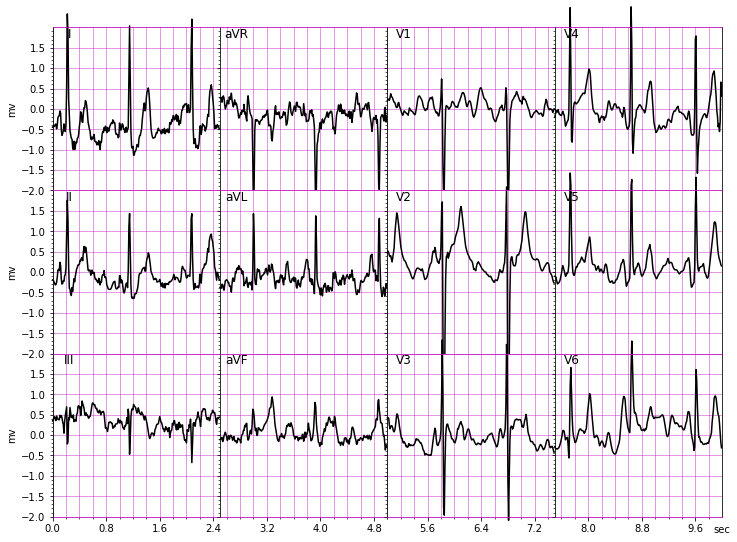

In [ ]:
for data_type in ("val", "test", "train",):
    print(f"SAP attacking {data_type} set")
    print("======================")
    examples = SAP.generate_examples(
            saved_file="drive/MyDrive/CSC2516_PTBXL/model_xresnet_20210418_014941.pt",
            dataset_file=file,
            data_type = data_type,
            device = "cuda",
            n = 5000,
            batch_size=32
        )
    assert examples is not None
    # Performance post-attack
    dataset = util.PTBXLDataset(file=file, data_type=data_type)
    dataset = util.PTBXLDataset(file=file, X=examples, y=dataset.y[0:len(examples), ...])
    dataset, y_pred = util.get_prediction(
        saved_file="drive/MyDrive/CSC2516_PTBXL/model_xresnet_20210418_014941.pt", 
        dataset=dataset
    )
    sensitivity_specificity_curves = util.get_sensitivity_specificity_curves(
        truth=dataset.y, pred=y_pred
    )
    fig, ax = plt.subplots()
    ax.plot(1-sensitivity_specificity_curves[..., 1].T, sensitivity_specificity_curves[..., 0].T)
    ax.set_title(f"{data_type}")

    print(f"{data_type} AUC for each category")
    auc = np.trapz(x=1-sensitivity_specificity_curves[..., 1], y=sensitivity_specificity_curves[..., 0], axis=1)
    print(auc)
    print(f"{data_type} AUC mean")
    print(auc.mean())
    util.plot_ecg(dataset.X[0, ...])

# Code snippets

## Copy model to Google Drive

In [ ]:
!cp "/content/model_xresnet_20210418_014941.pt" 'drive/MyDrive/CSC2516_PTBXL/model_xresnet_20210418_014941.pt'

In [ ]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


## Adversarial visualization

In [ ]:
data_type = "train"


In [ ]:
# sap_examples = SAP.generate_examples(
#         saved_file="drive/MyDrive/CSC2516_PTBXL/model_xresnet_20210418_014941.pt",
#         dataset_file=file,
#         data_type = "train",
#         device = "cuda",
#         n = 32,
#         batch_size=32
#     )
assert sap_examples is not None
# Performance post-attack
dataset = util.PTBXLDataset(file=file, data_type=data_type)
dataset = util.PTBXLDataset(file=file, X=sap_examples, y=dataset.y[0:len(sap_examples), ...])
dataset, y_pred_sap = util.get_prediction(
    saved_file="drive/MyDrive/CSC2516_PTBXL/model_xresnet_20210418_014941.pt", 
    dataset=dataset
)

In [ ]:
# fgsm_examples = FGSM.generate_examples(
#         saved_file="drive/MyDrive/CSC2516_PTBXL/model_xresnet_20210418_014941.pt",
#         dataset_file=file,
#         data_type = "train",
#         device = "cuda",
#         n = 32, 
#         epsilon=0.05
#     )
assert fgsm_examples is not None
# Performance post-attack
dataset = util.PTBXLDataset(file=file, data_type=data_type)
dataset = util.PTBXLDataset(file=file, X=fgsm_examples, y=dataset.y[0:len(fgsm_examples), ...])
dataset, y_pred_fgsm = util.get_prediction(
    saved_file="drive/MyDrive/CSC2516_PTBXL/model_xresnet_20210418_014941.pt", 
    dataset=dataset
)

In [ ]:
dataset = util.PTBXLDataset(file=file, data_type=data_type)
y_truth = dataset.y[0:len(fgsm_examples), ...]
dataset = util.PTBXLDataset(file=file, X=dataset.X[0:len(fgsm_examples), ...], y=dataset.y[0:len(fgsm_examples), ...])
dataset, y_pred_original = util.get_prediction(
    saved_file="drive/MyDrive/CSC2516_PTBXL/model_xresnet_20210418_014941.pt", 
    dataset=dataset
)

In [ ]:
(y_pred_original - y_pred_fgsm).max(axis=1).argmax()

13

In [ ]:
pd.DataFrame([y_truth[13],y_pred_original[13],y_pred_fgsm[13],y_pred_sap[13]], columns=dataset.statements["description"])

description  sinus rhythm  ...  trigeminal pattern (unknown origin, SV or Ventricular)
0                0.000000  ...                                           0.000000     
1                0.000217  ...                                           0.000767     
2                0.399378  ...                                           0.002974     
3                0.999992  ...                                           0.000024     

[4 rows x 12 columns]

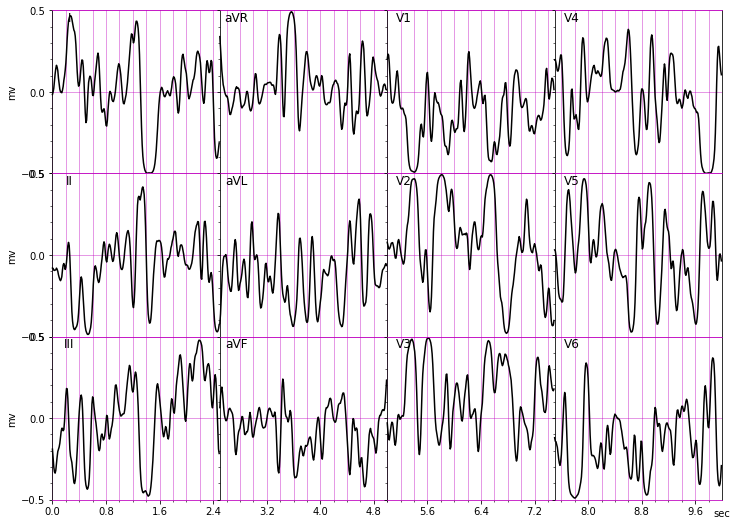

In [ ]:
fig, ax = util.plot_ecg(sap_examples[13]-dataset.X[13])
for a in ax.flat:
    a.set(ylim=(-0.5, 0.5))
fig.savefig(data_folder / "SAP_add.pdf")

In [ ]:
1+1

2

array([2.1685004e-04, 5.0706015e-04, 3.1570122e-03, 4.5377837e-04,
       4.5706925e-04, 8.2830280e-02, 5.5909354e-02, 9.3351376e-01,
       1.9041263e-05, 9.6105452e-04, 4.1227649e-05, 7.6685165e-04],
      dtype=float32)

In [ ]:
data_type = "train"

# examples = SAP.generate_examples(
#         saved_file="drive/MyDrive/CSC2516_PTBXL/model_xresnet_20210418_014941.pt",
#         dataset_file=file,
#         data_type = "train",
#         device = "cuda",
#         n = 32,
#         batch_size=32
#     )
assert examples is not None
# Performance post-attack
dataset = util.PTBXLDataset(file=file, data_type=data_type)
dataset = util.PTBXLDataset(file=file, X=examples, y=dataset.y[0:len(examples), ...])
dataset, y_pred = util.get_prediction(
    saved_file="drive/MyDrive/CSC2516_PTBXL/model_xresnet_20210418_014941.pt", 
    dataset=dataset
)


"""
for data_type in ("val", "test", "train",):
    print(f"SAP attacking {data_type} set")
    print("======================")
    examples = SAP.generate_examples(
            saved_file="drive/MyDrive/CSC2516_PTBXL/model_xresnet_20210418_014941.pt",
            dataset_file=file,
            data_type = data_type,
            device = "cuda",
            n = 5000,
            batch_size=32
        )
    assert examples is not None
    # Performance post-attack
    dataset = util.PTBXLDataset(file=file, data_type=data_type)
    dataset = util.PTBXLDataset(file=file, X=examples, y=dataset.y[0:len(examples), ...])
    dataset, y_pred = util.get_prediction(
        saved_file="drive/MyDrive/CSC2516_PTBXL/model_xresnet_20210418_014941.pt", 
        dataset=dataset
    )
    sensitivity_specificity_curves = util.get_sensitivity_specificity_curves(
        truth=dataset.y, pred=y_pred
    )
    fig, ax = plt.subplots()
    ax.plot(1-sensitivity_specificity_curves[..., 1].T, sensitivity_specificity_curves[..., 0].T)
    ax.set_title(f"{data_type}")

    print(f"{data_type} AUC for each category")
    auc = np.trapz(x=1-sensitivity_specificity_curves[..., 1], y=sensitivity_specificity_curves[..., 0], axis=1)
    print(auc)
    print(f"{data_type} AUC mean")
    print(auc.mean())
    util.plot_ecg(dataset.X[0, ...])
"""

'\nfor data_type in ("val", "test", "train",):\n    print(f"SAP attacking {data_type} set")\n    print("======================")\n    examples = SAP.generate_examples(\n            saved_file="drive/MyDrive/CSC2516_PTBXL/model_xresnet_20210418_014941.pt",\n            dataset_file=file,\n            data_type = data_type,\n            device = "cuda",\n            n = 5000,\n            batch_size=32\n        )\n    assert examples is not None\n    # Performance post-attack\n    dataset = util.PTBXLDataset(file=file, data_type=data_type)\n    dataset = util.PTBXLDataset(file=file, X=examples, y=dataset.y[0:len(examples), ...])\n    dataset, y_pred = util.get_prediction(\n        saved_file="drive/MyDrive/CSC2516_PTBXL/model_xresnet_20210418_014941.pt", \n        dataset=dataset\n    )\n    sensitivity_specificity_curves = util.get_sensitivity_specificity_curves(\n        truth=dataset.y, pred=y_pred\n    )\n    fig, ax = plt.subplots()\n    ax.plot(1-sensitivity_specificity_curves[...,

In [ ]:
y_pred

array([[5.26770532e-01, 5.96836805e-02, 1.24765979e-02, 2.88929213e-02,
        2.14706454e-02, 8.26158524e-02, 2.80904919e-01, 3.18354100e-01,
        3.23637301e-04, 3.08706407e-02, 6.38311729e-03, 2.38186494e-02],
       [3.01484461e-03, 1.11125782e-02, 1.26087805e-04, 6.80448939e-05,
        1.94666078e-04, 3.02550364e-02, 9.07118781e-04, 9.66905236e-01,
        2.34616036e-05, 1.46436738e-04, 4.61533564e-05, 7.40292540e-04],
       [1.26973674e-01, 1.46735549e-01, 8.99246335e-03, 1.09060053e-02,
        2.46490072e-02, 8.01731721e-02, 3.84471118e-01, 6.48419082e-01,
        5.24537347e-04, 1.15270307e-02, 9.41809546e-03, 2.49639191e-02],
       [5.66496015e-01, 1.52289718e-02, 4.82280552e-03, 1.52154546e-02,
        2.90064677e-03, 1.24243572e-01, 9.57819342e-04, 5.13911366e-01,
        1.10096601e-03, 3.01718172e-02, 1.17235899e-03, 3.73688457e-03],
       [7.05901623e-01, 3.17930542e-02, 1.66681986e-02, 3.47839184e-02,
        9.43769328e-03, 4.30421025e-01, 1.94652285e-02, 9.05

In [ ]:
dataset = util.PTBXLDataset(file=file, data_type=data_type)
dataset = util.PTBXLDataset(file=file, X=dataset.X[0:len(examples), ...], y=dataset.y[0:len(examples), ...])
dataset, y_pred_original = util.get_prediction(
    saved_file="drive/MyDrive/CSC2516_PTBXL/model_xresnet_20210418_014941.pt", 
    dataset=dataset
)

In [ ]:
y_pred_original

array([[9.45873489e-06, 2.09766531e-05, 2.48583005e-04, 5.42751841e-05,
        6.13222830e-04, 4.26112339e-02, 9.33116861e-03, 9.82001662e-01,
        7.06971014e-06, 1.00869707e-04, 3.59629812e-05, 4.52925480e-04],
       [9.95850004e-03, 4.56075091e-03, 4.75102998e-02, 1.22086436e-03,
        4.76291752e-04, 2.49752223e-01, 8.61679196e-01, 7.59473816e-02,
        3.24632274e-05, 8.53433099e-04, 1.56128342e-04, 9.92620643e-03],
       [5.71708233e-06, 1.12355854e-04, 1.50275679e-04, 2.21169757e-05,
        2.95042060e-04, 1.99619532e-02, 6.01023529e-03, 9.87260222e-01,
        5.80712913e-06, 5.01453978e-05, 2.00738687e-05, 2.36657375e-04],
       [7.62704411e-04, 1.35044614e-03, 3.16747068e-03, 1.02835731e-03,
        5.38893277e-04, 1.50761813e-01, 1.80526316e-04, 8.76071155e-01,
        7.65988661e-04, 8.82390328e-03, 2.03302290e-04, 7.85132695e-04],
       [7.88093239e-05, 1.69105086e-04, 1.89273662e-04, 6.87874708e-05,
        3.85985390e-04, 6.48585111e-02, 6.09227363e-03, 9.64

In [ ]:
((y_pred_original - y_pred)**2).mean(axis=1).argmax()

29

In [ ]:
y_pred_original[29]

array([7.2230371e-08, 2.9912471e-06, 9.4143114e-05, 2.2014366e-04,
       6.4262917e-04, 3.9557498e-02, 5.9930950e-05, 9.7255784e-01,
       8.8647066e-05, 4.8245192e-06, 2.7115308e-04, 2.0439384e-04],
      dtype=float32)

In [ ]:
y_pred[29]

array([0.05777935, 0.10946901, 0.01941119, 0.00284047, 0.9469418 ,
       0.02837571, 0.05755932, 0.10228599, 0.04115191, 0.02798344,
       0.92860764, 0.07876796], dtype=float32)

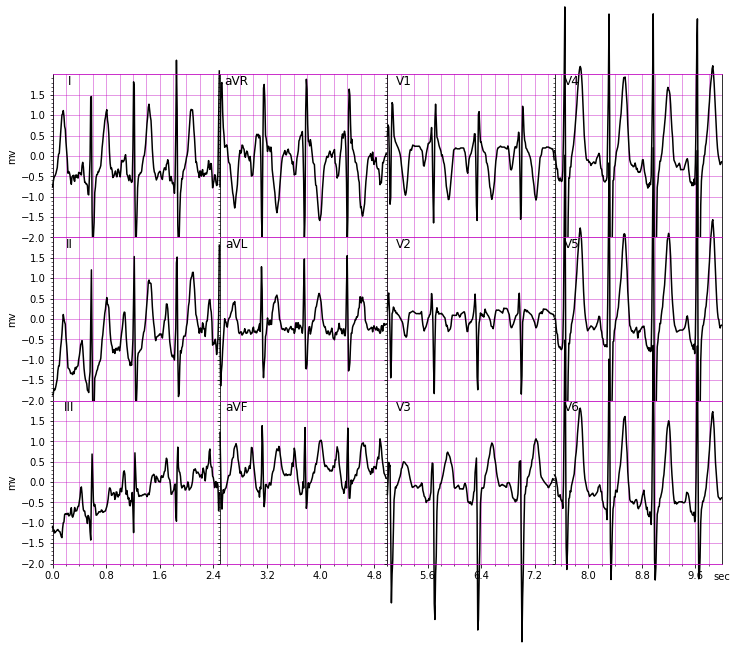

In [ ]:
fig, ax = util.plot_ecg(dataset.X[29])
fig.savefig(data_folder / "original.pdf")

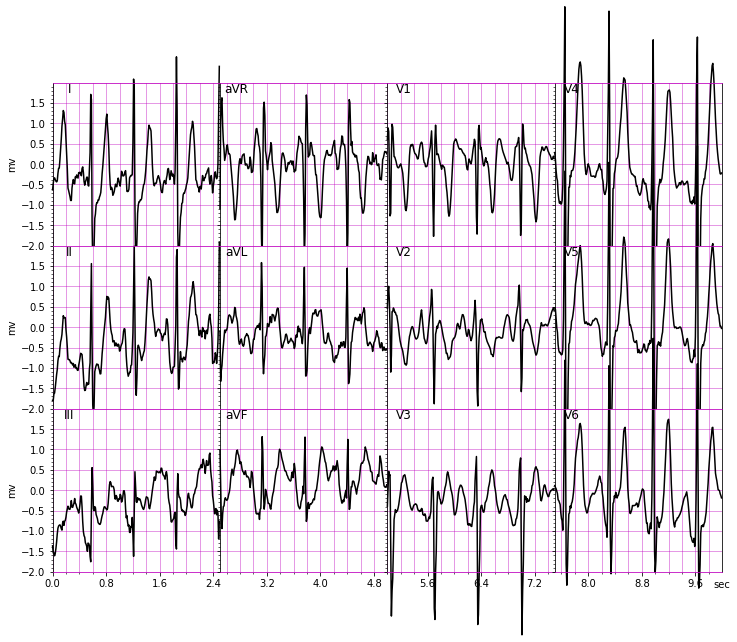

In [ ]:
fig, ax = util.plot_ecg(examples[29])
fig.savefig(data_folder / "SAP_example.pdf")

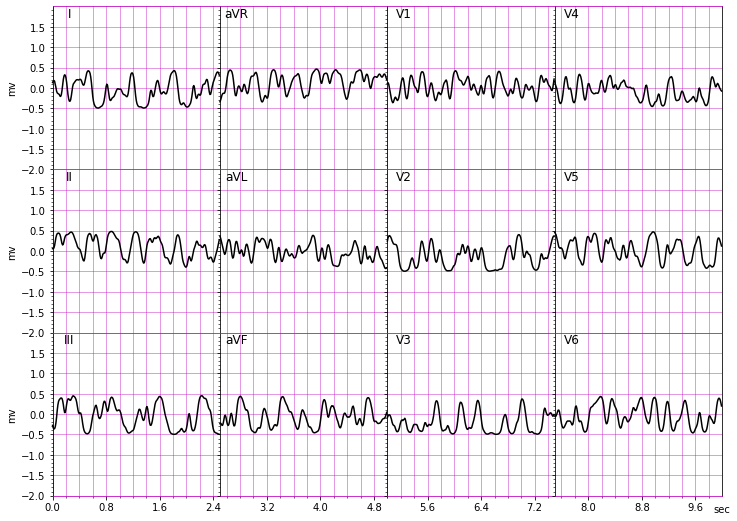

In [ ]:
fig, ax = util.plot_ecg(examples[29]-dataset.X[29])
fig.savefig(data_folder / "SAP_add.pdf")

In [ ]:
data_folder

PosixPath('drive/MyDrive/CSC2516_PTBXL')

In [ ]:
data_type = "train"

examples = FGSM.generate_examples(
        saved_file="drive/MyDrive/CSC2516_PTBXL/model_xresnet_20210418_014941.pt",
        dataset_file=file,
        data_type = "train",
        device = "cuda",
        n = 32, 
        epsilon=0.05
    )
assert examples is not None
# Performance post-attack
dataset = util.PTBXLDataset(file=file, data_type=data_type)
dataset = util.PTBXLDataset(file=file, X=examples, y=dataset.y[0:len(examples), ...])
dataset, y_pred = util.get_prediction(
    saved_file="drive/MyDrive/CSC2516_PTBXL/model_xresnet_20210418_014941.pt", 
    dataset=dataset
)

Generating:0/16854


In [ ]:
y_pred[29]

array([2.20616556e-07, 9.79358265e-06, 1.00486555e-04, 2.99256615e-04,
       8.59517488e-04, 5.01020551e-02, 7.08800289e-05, 9.64034855e-01,
       1.28431595e-04, 1.45620334e-05, 4.26214567e-04, 2.80226232e-04],
      dtype=float32)

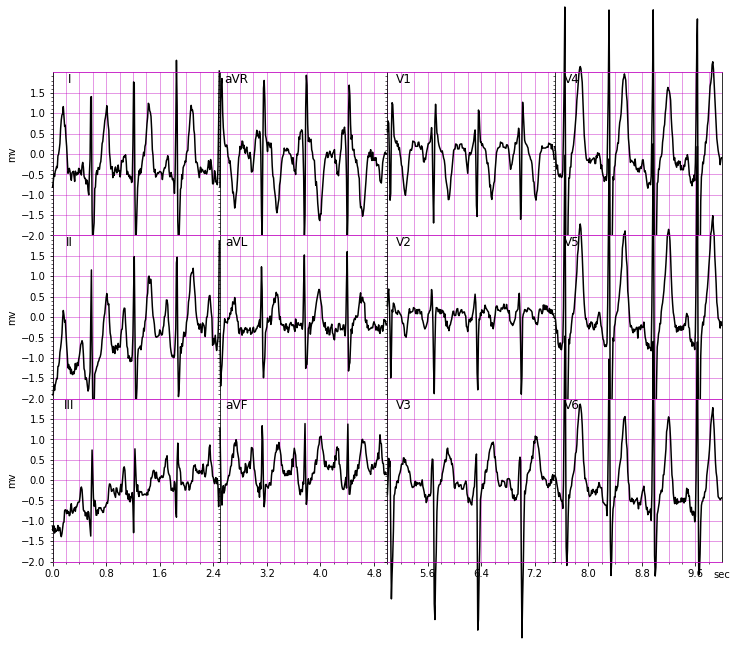

In [ ]:
fig, ax = util.plot_ecg(examples[29])
fig.savefig(data_folder / "FGSM_example.pdf")

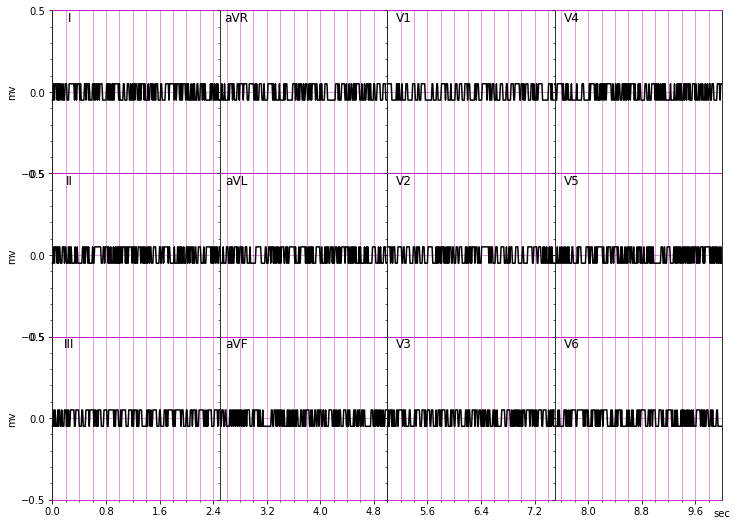

In [ ]:
dataset = util.PTBXLDataset(file=file, data_type=data_type)
fig, axes = util.plot_ecg(examples[29]-dataset.X[29])
for ax in axes.flat:
    ax.set(ylim=(-0.5, +0.5))
fig.savefig(data_folder / "FGSM_add.pdf")

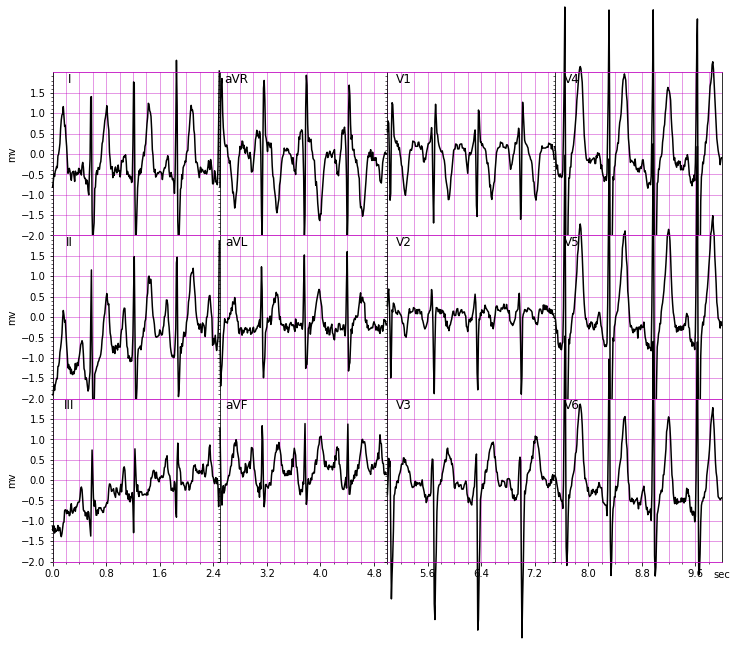

In [ ]:
fig, axes = util.plot_ecg(examples[29])
# for ax in axes.flat:
#     ax.set(ylim=(-0.5, +0.5))
fig.savefig(data_folder / "FGSM_example.pdf")

In [ ]:
pd.Series(dataset.y[29], index=dataset.statements["description"])

description
sinus rhythm                                              0
atrial fibrillation                                       0
sinus tachycardia                                         0
sinus arrhythmia                                          0
sinus bradycardia                                         0
normal functioning artificial pacemaker                   0
supraventricular arrhythmia                               0
bigeminal pattern (unknown origin, SV or Ventricular)     1
atrial flutter                                            0
supraventricular tachycardia                              0
paroxysmal supraventricular tachycardia                   0
trigeminal pattern (unknown origin, SV or Ventricular)    0
dtype: int32

In [ ]:
pd.Series(y_pred[29], index=dataset.statements["description"])

description
sinus rhythm                                              2.206166e-07
atrial fibrillation                                       9.793583e-06
sinus tachycardia                                         1.004866e-04
sinus arrhythmia                                          2.992566e-04
sinus bradycardia                                         8.595175e-04
normal functioning artificial pacemaker                   5.010206e-02
supraventricular arrhythmia                               7.088003e-05
bigeminal pattern (unknown origin, SV or Ventricular)     9.640349e-01
atrial flutter                                            1.284316e-04
supraventricular tachycardia                              1.456203e-05
paroxysmal supraventricular tachycardia                   4.262146e-04
trigeminal pattern (unknown origin, SV or Ventricular)    2.802262e-04
dtype: float32

In [ ]:
pd.Series(y_pred_original[29], index=dataset.statements["description"])

description
sinus rhythm                                              7.223037e-08
atrial fibrillation                                       2.991247e-06
sinus tachycardia                                         9.414311e-05
sinus arrhythmia                                          2.201437e-04
sinus bradycardia                                         6.426292e-04
normal functioning artificial pacemaker                   3.955750e-02
supraventricular arrhythmia                               5.993095e-05
bigeminal pattern (unknown origin, SV or Ventricular)     9.725578e-01
atrial flutter                                            8.864707e-05
supraventricular tachycardia                              4.824519e-06
paroxysmal supraventricular tachycardia                   2.711531e-04
trigeminal pattern (unknown origin, SV or Ventricular)    2.043938e-04
dtype: float32